## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:

##Camera distoration calibration
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


# undistor the given image using given matrix
def undistort(img, ret, mtx, dist, rvecs, tvecs):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [2]:
## Use color transforms, gradients, etc., to create a thresholded binary image.
def pipeline(img, s_thresh=(150, 255), sx_thresh=(150,250,10,50), 
h_thresh=(0,100), v_thresh=(20,100), l_thresh=(230,255)):
    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hsv[:,:,0]
    v_channel = hsv[:,:,2]
    sobel_kernel=3
    # Sobel x
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=15) # Take the derivative in x
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=15)
    #abs_sobel = (sobelx**2 + sobely**2)**(1/2) # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

    
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    sxbinary[(scaled_sobely >= sx_thresh[2]) & (scaled_sobely <= sx_thresh[3])] = 1

    # Threshold h color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Threshold l color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold v color channel
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    # Threshold s color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel
    color_binary = np.dstack((h_binary, s_binary, sxbinary)) * 255
    #color_binary_sx_s = np.dstack((h_binary, s_binary, l_binary)) * 255

    placeholder = 0
    
    return (color_binary, placeholder)


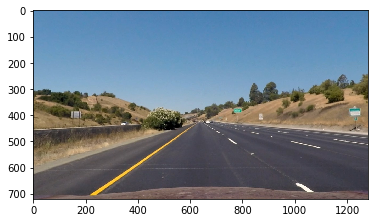

In [36]:
##Perspective change
##Local python IDE were used to get the cursor on the image
#the four points chosen are[[244.31, 705]],[[1047.55,695.87]],[[578.51, 465.73]],[[700,464.22]]
pers_change_img = cv2.imread('./test_images/straight_lines1.jpg')
pers_change_img = cv2.cvtColor(pers_change_img, cv2.COLOR_RGB2BGR)
pers_change_img = undistort(pers_change_img, ret, mtx, dist, rvecs, tvecs)
plt.imshow(pers_change_img)
plt.show()

#Source points and destnationa points

src = np.float32([[[258.6, 695]],[[1047.55,695.87]],[[578.51, 465.73]],[[700,464.22]]])
dst = np.float32([[[258.6,695]],[[1047.55, 695]], [[258.6,0]],[[1047.55, 0]]])  
#get the transform matrix and 
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# 
def pers_change(img):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

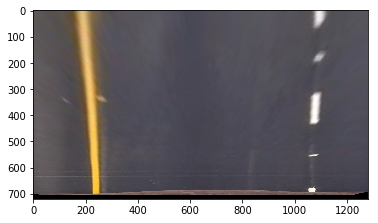

In [35]:
pers_change_img = cv2.imread('./test_images/straight_lines1.jpg')
pers_change_img = cv2.cvtColor(pers_change_img, cv2.COLOR_RGB2BGR)
pers_change_img = undistort(pers_change_img, ret, mtx, dist, rvecs, tvecs)
plt.imshow(pers_change(pers_change_img))
plt.show()

In [7]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 180
    # Set minimum number of pixels found to recenter window
    minpix = 20
    

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit


In [8]:
def binary_warp(img):
    output = np.zeros((img.shape[0],img.shape[1]))
    r = img[::,::,0]
    g = img[::,::,1]
    b = img[::,::,2]
    output[(r > 60)] = 1
    output[(g > 60)] = 1
    output[(b > 60)] = 1
    return output

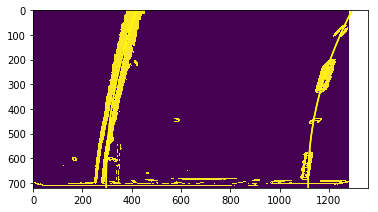

In [37]:
#test for now
img = cv2.imread('./test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = undistort(img, ret, mtx, dist, rvecs, tvecs)

pers_changed = pers_change(img)
#plt.imshow(pers_changed)
pipe = pipeline(pers_changed, s_thresh=(100, 180), sx_thresh=(20,250,20,60), 
h_thresh=(190,250))[0]  #, s_thresh=(120, 255), sx_thresh=(40, 240), h_thresh=(180,190)(30, 240)
#s_thresh=(90, 190), sx_thresh=(65, 210), h_thresh=(180,190)
binary_warped = binary_warp(pipe)*255

plt.imshow(binary_warped) 
output = fit_polynomial(binary_warped)
out_img, left_fit, right_fit = fit_polynomial(binary_warped)

#plt.imshow(out_img)
plt.show()


In [14]:
# Measure Curvature
def measure_curvature_real(left_fit_cr,right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!

    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    fit = lambda a, b: (1 + (2*a*y_eval+b)**2)**(3/2)/abs(2*a)
    left_curverad = round(fit(left_fit_cr[0], left_fit_cr[1]), 3)  ## Implement the calculation of the left line here
    right_curverad = round(fit(right_fit_cr[0], right_fit_cr[1]), 3)   ## Implement the calculation of the right line here

    return left_curverad, right_curverad

In [15]:
# test the image
left_fit_cr= output[1]
right_fit_cr = output[2]
measure_curvature_real(left_fit_cr,right_fit_cr)

(2151.3139999999999, 1637.028)

In [16]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/800 # meters per pixel in x dimension
#measure the center position
def center_pos(img, left_fit_cr, right_fit_cr):
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    y_eval = np.max(ploty)
    fit = lambda y,a, b, c: a*y**2 + b*y + c
    # position of the bottom lane for both left and right lane
    left_pos = fit(y_eval, left_fit_cr[0], left_fit_cr[1], left_fit_cr[2])  ## Implement the calculation of the left line here
    right_pos = fit(y_eval, right_fit_cr[0], right_fit_cr[1], right_fit_cr[2])   ## Implement the calculation of the right line here
    lane_mid = (left_pos + right_pos)/2 #Position of the middle of the lane
    car_mid = img.shape[1]/2
    offset = (car_mid - lane_mid) * xm_per_pix #offset of the car in meters, positive means offset to right, vice versa
    offset = round(offset, 3)
    
    if offset > 0:
        text = ("Vhicle is {} m offset to the right.".format(abs(offset)))
    else:
        text = ("Vhicle is {} m offset to the left.".format(abs(offset)))
                
    return text



In [17]:
#center_pos(binary_warped, left_fit_cr, right_fit_cr)

In [60]:
#Warp the detected lane boundaries back onto the original image.
def warp_back( image, warped, left_fit_cr, right_fit_cr):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    # Recast the x and y points into usable format for cv2.fillPoly()
    a1,b1,c1 = left_fit_cr[0], left_fit_cr[1], left_fit_cr[2]
    a2,b2,c2 = right_fit_cr[0], right_fit_cr[1], right_fit_cr[2]
    # position of the bottom lane for both left and right lane
    left_fitx = np.array([a1*y**2 + b1*y + c1 for y in ploty])
    right_fitx = np.array([a2*y**2 + b2*y + c2 for y in ploty])

    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

    
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.fillPoly(color_warp, pts.astype(np.int32), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    #result = cv2.addWeighted(pers_change(image), 1, color_warp, 0.3, 0)
    return result

    

In [23]:
#test
#warp_back(img, binary_warp(output[0]), left_fit_cr, right_fit_cr)


In [63]:
class Line():
    def __init__(self, left_fit , right_fit):
        self.left_fit = left_fit
        self.right_fit = right_fit
        # was the line detected in the last iteration?
        self.detected = False 
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    def check_update(self, new_left, new_right):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/800 # meters per pixel in x dimension
        y_evl = 700 #evaluate the distance at bottom
        
        x = lambda y, a, b, c: a*y**2 + b*y + c
        a1,b1,c1 = new_left
        a2,b2,c2 = new_right
        left_pos = x(y_evl, a1,b1,c1)
        right_pos = x(y_evl, a2,b2,c2)
        
        lane_width = (right_pos - left_pos) * xm_per_pix
        print("width is:", lane_width)
        if (3.45 < lane_width < 4.5) or self.detected == False:
            self.left_fit = new_left
            self.right_fit = new_right
            self.detected = True

    
line = Line((0,0,0),(0,0,0))
            

width is: 3.78964894183


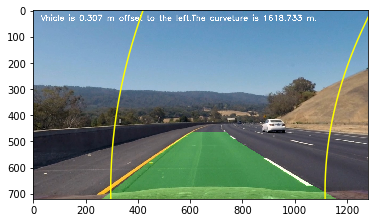

In [64]:
#combine all the functions to process image
def image_process(img):
    global line
    #Undistort the image
    img = undistort(img, ret, mtx, dist, rvecs, tvecs)
    top_view = pers_change(img)
    pipe = pipeline(top_view, s_thresh=(100, 180), sx_thresh=(20,250,20,60), 
h_thresh=(190,250))[0] #s_thresh=(60, 130), sx_thresh=(15, 240), h_thresh=(180,210)(30, 240)
    #s_thresh=(120, 250), sx_thresh=(65, 210), h_thresh=(80,240)
    binary_warped = binary_warp(pipe) * 255
    out_img, left_fit, right_fit = fit_polynomial(binary_warped)

    line.check_update(left_fit, right_fit)
        
    result  = warp_back(img, binary_warp(out_img), line.left_fit, line.right_fit)
    # get the position of vehicle and lane curveture
    left_curverad, right_curverad = measure_curvature_real(line.left_fit,line.right_fit)
    curverad = round((left_curverad + right_curverad)/2, 3)  #use the mean value as curveture
    curveture_str = ('The curveture is {} m.'.format(curverad))
    pos = center_pos(binary_warped, left_fit, right_fit) 
    text = pos + curveture_str
    ## add text on image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, text,(30,40), font, 1,(255,255,255),2,cv2.LINE_AA)
    return result
    
    

img = cv2.imread('./test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
result = image_process(img)   

plt.imshow(result)
plt.show()

width is: 3.8646417717


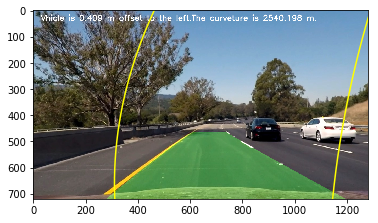

width is: 4.11200689853


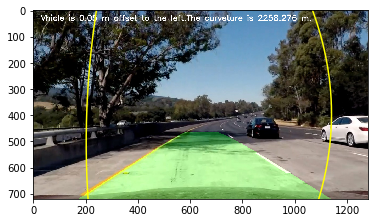

width is: 3.69593529772


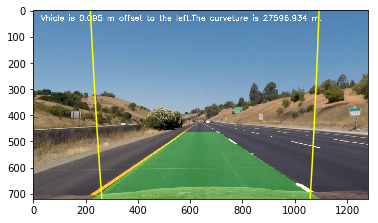

width is: 3.76134097493


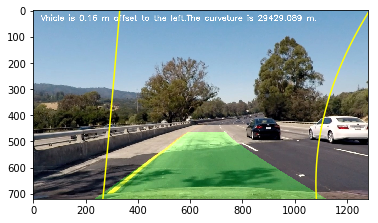

width is: 3.80622915943


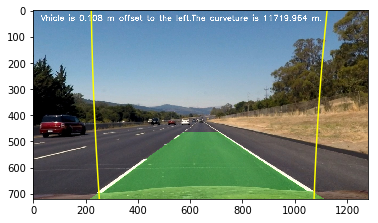

width is: 2.92037038998


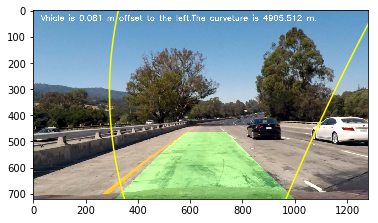

width is: 3.51240074284


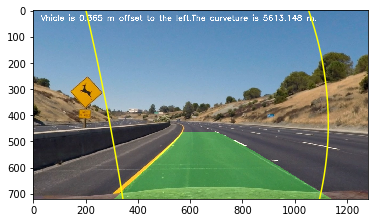

width is: 3.72828261061


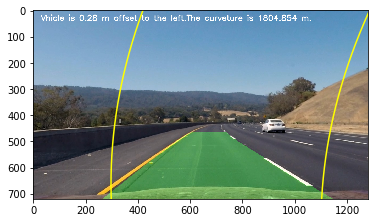

In [62]:

import os
imlist = os.listdir("./test_images/")
for image_name in imlist:
    img = cv2.imread('./test_images/'+image_name)
    result = image_process(img)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    cv2.imwrite('./output_images/'+image_name, result)
    plt.show()


width is: 3.80505327144
[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


  0%|          | 1/1261 [00:00<13:51,  1.52it/s]

width is: 3.80505327144


  0%|          | 2/1261 [00:01<14:03,  1.49it/s]

width is: 3.79436341674


  0%|          | 3/1261 [00:02<14:03,  1.49it/s]

width is: 3.86722540697


  0%|          | 4/1261 [00:02<14:01,  1.49it/s]

width is: 3.87291775567


  0%|          | 5/1261 [00:03<13:51,  1.51it/s]

width is: 3.80431835214


  0%|          | 6/1261 [00:03<13:45,  1.52it/s]

width is: 3.77775637338


  1%|          | 7/1261 [00:04<13:41,  1.53it/s]

width is: 3.7706988578


  1%|          | 8/1261 [00:05<13:41,  1.53it/s]

width is: 3.74231643327


  1%|          | 9/1261 [00:05<13:39,  1.53it/s]

width is: 3.77698484236


  1%|          | 10/1261 [00:06<14:24,  1.45it/s]

width is: 3.78347465045


  1%|          | 11/1261 [00:07<14:05,  1.48it/s]

width is: 3.79751357413


  1%|          | 12/1261 [00:08<13:52,  1.50it/s]

width is: 3.82271297076


  1%|          | 13/1261 [00:08<13:49,  1.50it/s]

width is: 3.7614677968


  1%|          | 14/1261 [00:09<14:00,  1.48it/s]

width is: 3.77257297433


  1%|          | 15/1261 [00:10<13:47,  1.51it/s]

width is: 3.79658389213


  1%|▏         | 16/1261 [00:10<13:45,  1.51it/s]

width is: 3.78849066929


  1%|▏         | 17/1261 [00:11<13:41,  1.51it/s]

width is: 3.77252690879


  1%|▏         | 18/1261 [00:11<13:39,  1.52it/s]

width is: 3.76587198882


  2%|▏         | 19/1261 [00:12<13:42,  1.51it/s]

width is: 3.72741404506


  2%|▏         | 20/1261 [00:13<13:39,  1.51it/s]

width is: 3.73801464779


  2%|▏         | 21/1261 [00:13<13:34,  1.52it/s]

width is: 3.75183181383


  2%|▏         | 22/1261 [00:14<13:27,  1.53it/s]

width is: 3.78175427597


  2%|▏         | 23/1261 [00:15<13:23,  1.54it/s]

width is: 3.84774441008


  2%|▏         | 24/1261 [00:15<13:22,  1.54it/s]

width is: 3.85249920831


  2%|▏         | 25/1261 [00:16<13:18,  1.55it/s]

width is: 3.8477366552


  2%|▏         | 26/1261 [00:17<13:15,  1.55it/s]

width is: 3.86743558761


  2%|▏         | 27/1261 [00:17<13:15,  1.55it/s]

width is: 3.87163811875


  2%|▏         | 28/1261 [00:18<13:15,  1.55it/s]

width is: 3.91783889482


  2%|▏         | 29/1261 [00:19<13:10,  1.56it/s]

width is: 3.89686580176


  2%|▏         | 30/1261 [00:19<13:15,  1.55it/s]

width is: 3.86254418832


  2%|▏         | 31/1261 [00:20<13:18,  1.54it/s]

width is: 3.86273238485


  3%|▎         | 32/1261 [00:21<13:17,  1.54it/s]

width is: 3.86483082044


  3%|▎         | 33/1261 [00:21<13:17,  1.54it/s]

width is: 3.85896012034


  3%|▎         | 34/1261 [00:22<13:13,  1.55it/s]

width is: 3.87845871458


  3%|▎         | 35/1261 [00:22<13:14,  1.54it/s]

width is: 3.88761211423


  3%|▎         | 36/1261 [00:23<13:12,  1.55it/s]

width is: 3.8085046675


  3%|▎         | 37/1261 [00:24<13:13,  1.54it/s]

width is: 3.88536846814


  3%|▎         | 38/1261 [00:24<13:21,  1.53it/s]

width is: 3.81133998938


  3%|▎         | 39/1261 [00:25<13:19,  1.53it/s]

width is: 3.822293124


  3%|▎         | 40/1261 [00:26<13:21,  1.52it/s]

width is: 3.83460684951


  3%|▎         | 41/1261 [00:26<13:19,  1.53it/s]

width is: 3.83230017183


  3%|▎         | 42/1261 [00:27<13:14,  1.53it/s]

width is: 3.82943614396


  3%|▎         | 43/1261 [00:28<14:43,  1.38it/s]

width is: 3.80414597153


  3%|▎         | 44/1261 [00:29<14:37,  1.39it/s]

width is: 3.81185540891


  4%|▎         | 45/1261 [00:29<15:05,  1.34it/s]

width is: 3.81294638766


  4%|▎         | 46/1261 [00:30<15:03,  1.35it/s]

width is: 3.77768091775


  4%|▎         | 47/1261 [00:31<14:46,  1.37it/s]

width is: 3.79716708926


  4%|▍         | 48/1261 [00:32<14:47,  1.37it/s]

width is: 3.81125423962


  4%|▍         | 49/1261 [00:32<14:39,  1.38it/s]

width is: 3.83667981873


  4%|▍         | 50/1261 [00:33<14:42,  1.37it/s]

width is: 3.84363579629


  4%|▍         | 51/1261 [00:34<14:34,  1.38it/s]

width is: 3.84313251266


  4%|▍         | 52/1261 [00:35<14:41,  1.37it/s]

width is: 3.80210244186


  4%|▍         | 53/1261 [00:35<14:31,  1.39it/s]

width is: 3.79170843942


  4%|▍         | 54/1261 [00:36<14:37,  1.38it/s]

width is: 3.7913891026


  4%|▍         | 55/1261 [00:37<14:32,  1.38it/s]

width is: 3.77727486179


  4%|▍         | 56/1261 [00:37<14:56,  1.34it/s]

width is: 3.77716152809


  5%|▍         | 57/1261 [00:38<14:54,  1.35it/s]

width is: 3.77156650544


  5%|▍         | 58/1261 [00:39<15:04,  1.33it/s]

width is: 3.77850042954


  5%|▍         | 59/1261 [00:40<15:09,  1.32it/s]

width is: 3.76890166868


  5%|▍         | 60/1261 [00:41<15:12,  1.32it/s]

width is: 3.7688901423


  5%|▍         | 61/1261 [00:41<15:16,  1.31it/s]

width is: 3.7741271751


  5%|▍         | 62/1261 [00:42<15:17,  1.31it/s]

width is: 3.79615697396


  5%|▍         | 63/1261 [00:43<15:07,  1.32it/s]

width is: 3.80233878301


  5%|▌         | 64/1261 [00:44<15:00,  1.33it/s]

width is: 3.79089824694


  5%|▌         | 65/1261 [00:44<14:42,  1.36it/s]

width is: 3.80798894772


  5%|▌         | 66/1261 [00:45<14:48,  1.35it/s]

width is: 3.81390176621


  5%|▌         | 67/1261 [00:46<15:06,  1.32it/s]

width is: 3.81926543037


  5%|▌         | 68/1261 [00:47<15:01,  1.32it/s]

width is: 3.79985364018


  5%|▌         | 69/1261 [00:47<14:58,  1.33it/s]

width is: 3.75857688619


  6%|▌         | 70/1261 [00:48<14:51,  1.34it/s]

width is: 3.73351310432


  6%|▌         | 71/1261 [00:49<14:47,  1.34it/s]

width is: 3.69476097567


  6%|▌         | 72/1261 [00:50<14:40,  1.35it/s]

width is: 3.81493348218


  6%|▌         | 73/1261 [00:50<14:39,  1.35it/s]

width is: 3.833380166


  6%|▌         | 74/1261 [00:51<14:37,  1.35it/s]

width is: 3.76845120629


  6%|▌         | 75/1261 [00:52<14:33,  1.36it/s]

width is: 3.78509662857


  6%|▌         | 76/1261 [00:52<14:24,  1.37it/s]

width is: 3.79596003793


  6%|▌         | 77/1261 [00:53<14:31,  1.36it/s]

width is: 3.84716747346


  6%|▌         | 78/1261 [00:54<14:18,  1.38it/s]

width is: 3.81935023817


  6%|▋         | 79/1261 [00:55<14:23,  1.37it/s]

width is: 3.86283086845


  6%|▋         | 80/1261 [00:55<14:17,  1.38it/s]

width is: 3.87831009108


  6%|▋         | 81/1261 [00:56<14:24,  1.36it/s]

width is: 3.86593189766


  7%|▋         | 82/1261 [00:57<14:12,  1.38it/s]

width is: 3.8741381681


  7%|▋         | 83/1261 [00:58<14:19,  1.37it/s]

width is: 3.90220171317


  7%|▋         | 84/1261 [00:58<14:09,  1.39it/s]

width is: 3.92930383716


  7%|▋         | 85/1261 [00:59<14:15,  1.38it/s]

width is: 3.96540737084


  7%|▋         | 86/1261 [01:00<14:07,  1.39it/s]

width is: 3.98036535964


  7%|▋         | 87/1261 [01:00<14:12,  1.38it/s]

width is: 3.96475611633


  7%|▋         | 88/1261 [01:01<14:23,  1.36it/s]

width is: 3.98519686297


  7%|▋         | 89/1261 [01:02<14:12,  1.37it/s]

width is: 3.96265812419


  7%|▋         | 90/1261 [01:03<14:22,  1.36it/s]

width is: 3.96449432624


  7%|▋         | 91/1261 [01:03<14:08,  1.38it/s]

width is: 3.89064177677


  7%|▋         | 92/1261 [01:04<14:15,  1.37it/s]

width is: 3.86221920488


  7%|▋         | 93/1261 [01:05<14:20,  1.36it/s]

width is: 3.86626751892


  7%|▋         | 94/1261 [01:06<14:15,  1.36it/s]

width is: 3.82680563503


  8%|▊         | 95/1261 [01:06<15:01,  1.29it/s]

width is: 3.80972132843


  8%|▊         | 96/1261 [01:07<15:29,  1.25it/s]

width is: 3.75818510227


  8%|▊         | 97/1261 [01:08<15:15,  1.27it/s]

width is: 3.79602036815


  8%|▊         | 98/1261 [01:09<14:54,  1.30it/s]

width is: 3.8165095936


  8%|▊         | 99/1261 [01:10<14:37,  1.32it/s]

width is: 3.82723738916


  8%|▊         | 100/1261 [01:10<14:26,  1.34it/s]

width is: 3.82091199502


  8%|▊         | 101/1261 [01:11<14:24,  1.34it/s]

width is: 3.82808657094


  8%|▊         | 102/1261 [01:12<14:18,  1.35it/s]

width is: 3.79894912379


  8%|▊         | 103/1261 [01:12<14:21,  1.34it/s]

width is: 3.80037708198


  8%|▊         | 104/1261 [01:13<14:16,  1.35it/s]

width is: 3.76905355521


  8%|▊         | 105/1261 [01:14<14:15,  1.35it/s]

width is: 3.77549603622


  8%|▊         | 106/1261 [01:15<14:20,  1.34it/s]

width is: 3.76111086777


  8%|▊         | 107/1261 [01:15<14:09,  1.36it/s]

width is: 3.79391107855


  9%|▊         | 108/1261 [01:16<14:14,  1.35it/s]

width is: 3.78369135109


  9%|▊         | 109/1261 [01:17<13:59,  1.37it/s]

width is: 3.75250794598


  9%|▊         | 110/1261 [01:18<13:59,  1.37it/s]

width is: 3.76635654658


  9%|▉         | 111/1261 [01:18<13:53,  1.38it/s]

width is: 3.79169482512


  9%|▉         | 112/1261 [01:19<13:59,  1.37it/s]

width is: 3.84911892317


  9%|▉         | 113/1261 [01:20<13:45,  1.39it/s]

width is: 3.75960289614


  9%|▉         | 114/1261 [01:20<13:48,  1.38it/s]

width is: 3.8009432384


  9%|▉         | 115/1261 [01:21<13:51,  1.38it/s]

width is: 3.80059494514


  9%|▉         | 116/1261 [01:22<13:54,  1.37it/s]

width is: 3.80713966765


  9%|▉         | 117/1261 [01:23<13:43,  1.39it/s]

width is: 3.80999861467


  9%|▉         | 118/1261 [01:23<13:44,  1.39it/s]

width is: 3.72240150545


  9%|▉         | 119/1261 [01:24<14:07,  1.35it/s]

width is: 3.72444060347


 10%|▉         | 120/1261 [01:25<14:03,  1.35it/s]

width is: 3.74965628961


 10%|▉         | 121/1261 [01:26<14:00,  1.36it/s]

width is: 3.71963889409


 10%|▉         | 122/1261 [01:26<14:00,  1.36it/s]

width is: 3.73979257906


 10%|▉         | 123/1261 [01:27<14:00,  1.35it/s]

width is: 3.81094985346


 10%|▉         | 124/1261 [01:28<13:58,  1.36it/s]

width is: 3.7896346251


 10%|▉         | 125/1261 [01:29<13:58,  1.35it/s]

width is: 3.73814960788


 10%|▉         | 126/1261 [01:29<13:52,  1.36it/s]

width is: 3.80057765522


 10%|█         | 127/1261 [01:30<13:56,  1.36it/s]

width is: 3.79698200094


 10%|█         | 128/1261 [01:31<13:49,  1.37it/s]

width is: 3.81683594927


 10%|█         | 129/1261 [01:32<13:54,  1.36it/s]

width is: 3.80755156622


 10%|█         | 130/1261 [01:32<13:53,  1.36it/s]

width is: 3.78295383397


 10%|█         | 131/1261 [01:33<13:51,  1.36it/s]

width is: 3.75018867473


 10%|█         | 132/1261 [01:34<13:54,  1.35it/s]

width is: 3.70203985324


 11%|█         | 133/1261 [01:34<13:55,  1.35it/s]

width is: 3.72088232449


 11%|█         | 134/1261 [01:35<13:57,  1.35it/s]

width is: 3.69880363706


 11%|█         | 135/1261 [01:36<13:56,  1.35it/s]

width is: 3.70347722432


 11%|█         | 136/1261 [01:37<13:45,  1.36it/s]

width is: 3.70723333313


 11%|█         | 137/1261 [01:37<13:49,  1.35it/s]

width is: 3.71879570406


 11%|█         | 138/1261 [01:38<13:33,  1.38it/s]

width is: 3.75464074276


 11%|█         | 139/1261 [01:39<13:33,  1.38it/s]

width is: 3.74972817589


 11%|█         | 140/1261 [01:40<13:28,  1.39it/s]

width is: 3.76757725182


 11%|█         | 141/1261 [01:40<13:31,  1.38it/s]

width is: 3.7845635982


 11%|█▏        | 142/1261 [01:41<13:37,  1.37it/s]

width is: 3.7820571933


 11%|█▏        | 143/1261 [01:42<13:34,  1.37it/s]

width is: 3.77898741466


 11%|█▏        | 144/1261 [01:42<13:30,  1.38it/s]

width is: 3.76714328445


 11%|█▏        | 145/1261 [01:43<13:29,  1.38it/s]

width is: 3.70675031808


 12%|█▏        | 146/1261 [01:44<13:30,  1.37it/s]

width is: 3.74924869148


 12%|█▏        | 147/1261 [01:45<13:59,  1.33it/s]

width is: 3.75572941128


 12%|█▏        | 148/1261 [01:45<13:46,  1.35it/s]

width is: 3.75480896154


 12%|█▏        | 149/1261 [01:46<13:38,  1.36it/s]

width is: 3.75983513235


 12%|█▏        | 150/1261 [01:47<13:36,  1.36it/s]

width is: 3.79335170514


 12%|█▏        | 151/1261 [01:48<13:29,  1.37it/s]

width is: 3.74826996776


 12%|█▏        | 152/1261 [01:48<13:25,  1.38it/s]

width is: 3.75331608859


 12%|█▏        | 153/1261 [01:49<13:21,  1.38it/s]

width is: 3.79041518149


 12%|█▏        | 154/1261 [01:50<13:16,  1.39it/s]

width is: 3.79571703849


 12%|█▏        | 155/1261 [01:50<13:13,  1.39it/s]

width is: 3.80021611024


 12%|█▏        | 156/1261 [01:51<13:13,  1.39it/s]

width is: 3.80067630964


 12%|█▏        | 157/1261 [01:52<13:13,  1.39it/s]

width is: 3.81303475524


 13%|█▎        | 158/1261 [01:53<13:15,  1.39it/s]

width is: 3.80955834471


 13%|█▎        | 159/1261 [01:53<13:13,  1.39it/s]

width is: 3.75222808846


 13%|█▎        | 160/1261 [01:54<13:11,  1.39it/s]

width is: 3.82340939125


 13%|█▎        | 161/1261 [01:55<13:14,  1.38it/s]

width is: 3.87860084903


 13%|█▎        | 162/1261 [01:56<13:15,  1.38it/s]

width is: 3.89662528821


 13%|█▎        | 163/1261 [01:56<13:19,  1.37it/s]

width is: 3.90793513791


 13%|█▎        | 164/1261 [01:57<13:14,  1.38it/s]

width is: 3.90816466897


 13%|█▎        | 165/1261 [01:58<13:13,  1.38it/s]

width is: 3.85562780014


 13%|█▎        | 166/1261 [01:58<13:03,  1.40it/s]

width is: 3.89104201694


 13%|█▎        | 167/1261 [01:59<13:09,  1.39it/s]

width is: 3.86277526317


 13%|█▎        | 168/1261 [02:00<12:59,  1.40it/s]

width is: 3.86472890582


 13%|█▎        | 169/1261 [02:01<13:04,  1.39it/s]

width is: 3.89503311281


 13%|█▎        | 170/1261 [02:01<12:57,  1.40it/s]

width is: 3.91398252848


 14%|█▎        | 171/1261 [02:02<13:03,  1.39it/s]

width is: 3.89676388019


 14%|█▎        | 172/1261 [02:03<12:53,  1.41it/s]

width is: 3.83273812141


 14%|█▎        | 173/1261 [02:03<13:05,  1.39it/s]

width is: 3.91416245208


 14%|█▍        | 174/1261 [02:04<13:04,  1.39it/s]

width is: 3.83773239691


 14%|█▍        | 175/1261 [02:05<13:14,  1.37it/s]

width is: 3.89621938998


 14%|█▍        | 176/1261 [02:06<13:08,  1.38it/s]

width is: 3.83222859728


 14%|█▍        | 177/1261 [02:07<15:24,  1.17it/s]

width is: 3.90229092701


 14%|█▍        | 178/1261 [02:08<15:02,  1.20it/s]

width is: 3.9094369369


 14%|█▍        | 179/1261 [02:08<14:38,  1.23it/s]

width is: 3.95727616718


 14%|█▍        | 180/1261 [02:09<14:28,  1.25it/s]

width is: 3.95885891453


 14%|█▍        | 181/1261 [02:10<14:14,  1.26it/s]

width is: 3.92791763169


 14%|█▍        | 182/1261 [02:11<14:08,  1.27it/s]

width is: 3.96060057029


 15%|█▍        | 183/1261 [02:11<13:54,  1.29it/s]

width is: 3.96921996672


 15%|█▍        | 184/1261 [02:12<13:54,  1.29it/s]

width is: 3.96790062601


 15%|█▍        | 185/1261 [02:13<13:57,  1.28it/s]

width is: 3.91862154831


 15%|█▍        | 186/1261 [02:14<13:43,  1.31it/s]

width is: 3.88476115634


 15%|█▍        | 187/1261 [02:14<13:30,  1.33it/s]

width is: 3.89229500599


 15%|█▍        | 188/1261 [02:15<13:22,  1.34it/s]

width is: 3.86330249378


 15%|█▍        | 189/1261 [02:16<13:15,  1.35it/s]

width is: 3.84819875564


 15%|█▌        | 190/1261 [02:17<13:08,  1.36it/s]

width is: 3.84600792668


 15%|█▌        | 191/1261 [02:17<13:06,  1.36it/s]

width is: 3.81308797585


 15%|█▌        | 192/1261 [02:18<13:03,  1.36it/s]

width is: 3.79084944897


 15%|█▌        | 193/1261 [02:19<13:02,  1.36it/s]

width is: 3.77486374537


 15%|█▌        | 194/1261 [02:20<13:09,  1.35it/s]

width is: 3.78072980099


 15%|█▌        | 195/1261 [02:20<13:11,  1.35it/s]

width is: 3.77790130536


 16%|█▌        | 196/1261 [02:21<12:56,  1.37it/s]

width is: 3.81174198471


 16%|█▌        | 197/1261 [02:22<12:59,  1.36it/s]

width is: 3.8694012915


 16%|█▌        | 198/1261 [02:23<13:02,  1.36it/s]

width is: 3.91054848679


 16%|█▌        | 199/1261 [02:23<12:51,  1.38it/s]

width is: 3.94551730507


 16%|█▌        | 200/1261 [02:24<12:56,  1.37it/s]

width is: 3.97144114115


 16%|█▌        | 201/1261 [02:25<12:42,  1.39it/s]

width is: 3.98746762461


 16%|█▌        | 202/1261 [02:25<12:47,  1.38it/s]

width is: 3.94792623611


 16%|█▌        | 203/1261 [02:26<12:37,  1.40it/s]

width is: 3.93484655011


 16%|█▌        | 204/1261 [02:27<12:41,  1.39it/s]

width is: 3.95712159086


 16%|█▋        | 205/1261 [02:28<12:33,  1.40it/s]

width is: 3.95407389714


 16%|█▋        | 206/1261 [02:28<12:39,  1.39it/s]

width is: 3.9362407887


 16%|█▋        | 207/1261 [02:29<12:42,  1.38it/s]

width is: 3.89721404638


 16%|█▋        | 208/1261 [02:30<12:44,  1.38it/s]

width is: 3.86280863912


 17%|█▋        | 209/1261 [02:30<12:49,  1.37it/s]

width is: 3.89489864258


 17%|█▋        | 210/1261 [02:31<12:45,  1.37it/s]

width is: 3.92732657472


 17%|█▋        | 211/1261 [02:32<12:47,  1.37it/s]

width is: 3.96674903924


 17%|█▋        | 212/1261 [02:33<12:37,  1.39it/s]

width is: 3.9788188532


 17%|█▋        | 213/1261 [02:33<12:42,  1.37it/s]

width is: 3.96617540481


 17%|█▋        | 214/1261 [02:34<12:27,  1.40it/s]

width is: 3.94797486303


 17%|█▋        | 215/1261 [02:35<12:39,  1.38it/s]

width is: 3.95140789499


 17%|█▋        | 216/1261 [02:35<12:30,  1.39it/s]

width is: 3.96603459709


 17%|█▋        | 217/1261 [02:36<12:36,  1.38it/s]

width is: 3.94141220754


 17%|█▋        | 218/1261 [02:37<12:28,  1.39it/s]

width is: 3.94477097244


 17%|█▋        | 219/1261 [02:38<12:31,  1.39it/s]

width is: 3.89803110503


 17%|█▋        | 220/1261 [02:38<12:23,  1.40it/s]

width is: 3.83228011784


 18%|█▊        | 221/1261 [02:39<12:29,  1.39it/s]

width is: 3.82516842168


 18%|█▊        | 222/1261 [02:40<12:19,  1.40it/s]

width is: 3.83028140748


 18%|█▊        | 223/1261 [02:41<12:33,  1.38it/s]

width is: 3.85088066143


 18%|█▊        | 224/1261 [02:41<12:41,  1.36it/s]

width is: 3.85359812177


 18%|█▊        | 225/1261 [02:42<12:34,  1.37it/s]

width is: 3.86626651652


 18%|█▊        | 226/1261 [02:43<12:35,  1.37it/s]

width is: 3.86211117951


 18%|█▊        | 227/1261 [02:43<12:36,  1.37it/s]

width is: 3.87531800428


 18%|█▊        | 228/1261 [02:44<12:23,  1.39it/s]

width is: 3.89392374107


 18%|█▊        | 229/1261 [02:45<12:29,  1.38it/s]

width is: 3.88774194218


 18%|█▊        | 230/1261 [02:46<12:19,  1.40it/s]

width is: 3.90844889106


 18%|█▊        | 231/1261 [02:46<12:23,  1.39it/s]

width is: 3.89591274304


 18%|█▊        | 232/1261 [02:47<12:13,  1.40it/s]

width is: 3.91614751991


 18%|█▊        | 233/1261 [02:48<12:20,  1.39it/s]

width is: 3.86825079003


 19%|█▊        | 234/1261 [02:48<12:13,  1.40it/s]

width is: 3.95131751177


 19%|█▊        | 235/1261 [02:49<12:16,  1.39it/s]

width is: 4.00097281113


 19%|█▊        | 236/1261 [02:50<12:18,  1.39it/s]

width is: 3.97475938259


 19%|█▉        | 237/1261 [02:51<12:09,  1.40it/s]

width is: 3.84961405607


 19%|█▉        | 238/1261 [02:51<12:09,  1.40it/s]

width is: 3.86863765829


 19%|█▉        | 239/1261 [02:52<12:14,  1.39it/s]

width is: 3.89389540389


 19%|█▉        | 240/1261 [02:53<12:16,  1.39it/s]

width is: 3.930045823


 19%|█▉        | 241/1261 [02:54<12:16,  1.38it/s]

width is: 3.92066675319


 19%|█▉        | 242/1261 [02:54<12:19,  1.38it/s]

width is: 3.93790290518


 19%|█▉        | 243/1261 [02:55<12:13,  1.39it/s]

width is: 3.94019552631


 19%|█▉        | 244/1261 [02:56<12:15,  1.38it/s]

width is: 3.95433806772


 19%|█▉        | 245/1261 [02:56<12:08,  1.40it/s]

width is: 3.9033929278


 20%|█▉        | 246/1261 [02:57<12:13,  1.38it/s]

width is: 3.91920057219


 20%|█▉        | 247/1261 [02:58<11:59,  1.41it/s]

width is: 3.96850332521


 20%|█▉        | 248/1261 [02:59<12:04,  1.40it/s]

width is: 3.96407007027


 20%|█▉        | 249/1261 [02:59<12:29,  1.35it/s]

width is: 3.99209086128


 20%|█▉        | 250/1261 [03:00<12:32,  1.34it/s]

width is: 3.89470640199


 20%|█▉        | 251/1261 [03:01<12:16,  1.37it/s]

width is: 3.9480700692


 20%|█▉        | 252/1261 [03:02<12:20,  1.36it/s]

width is: 3.98157752732


 20%|██        | 253/1261 [03:02<12:08,  1.38it/s]

width is: 3.94408421223


 20%|██        | 254/1261 [03:03<12:14,  1.37it/s]

width is: 3.9677115089


 20%|██        | 255/1261 [03:04<12:00,  1.40it/s]

width is: 3.92837488585


 20%|██        | 256/1261 [03:04<12:09,  1.38it/s]

width is: 3.77041065806


 20%|██        | 257/1261 [03:05<12:01,  1.39it/s]

width is: 3.65844441541


 20%|██        | 258/1261 [03:06<12:08,  1.38it/s]

width is: 3.76656540893


 21%|██        | 259/1261 [03:07<12:00,  1.39it/s]

width is: 3.79582438434


 21%|██        | 260/1261 [03:07<12:10,  1.37it/s]

width is: 3.93012001762


 21%|██        | 261/1261 [03:08<14:28,  1.15it/s]

width is: 3.96448403703


 21%|██        | 262/1261 [03:09<13:51,  1.20it/s]

width is: 3.89586275195


 21%|██        | 263/1261 [03:10<13:11,  1.26it/s]

width is: 3.936547831


 21%|██        | 264/1261 [03:11<12:55,  1.29it/s]

width is: 3.94963390301


 21%|██        | 265/1261 [03:11<12:32,  1.32it/s]

width is: 3.95740812226


 21%|██        | 266/1261 [03:12<12:28,  1.33it/s]

width is: 3.9713847531


 21%|██        | 267/1261 [03:13<12:12,  1.36it/s]

width is: 3.90578744215


 21%|██▏       | 268/1261 [03:14<12:14,  1.35it/s]

width is: 3.93461764648


 21%|██▏       | 269/1261 [03:14<12:08,  1.36it/s]

width is: 4.00052227255


 21%|██▏       | 270/1261 [03:15<12:10,  1.36it/s]

width is: 4.08367750897


 21%|██▏       | 271/1261 [03:16<11:57,  1.38it/s]

width is: 4.01534966847


 22%|██▏       | 272/1261 [03:16<12:01,  1.37it/s]

width is: 3.8965201807


 22%|██▏       | 273/1261 [03:17<12:08,  1.36it/s]

width is: 3.89051120424


 22%|██▏       | 274/1261 [03:18<12:01,  1.37it/s]

width is: 3.86664226365


 22%|██▏       | 275/1261 [03:19<12:08,  1.35it/s]

width is: 3.88116106077


 22%|██▏       | 276/1261 [03:19<11:53,  1.38it/s]

width is: 3.88369792987


 22%|██▏       | 277/1261 [03:20<11:56,  1.37it/s]

width is: 3.85048045521


 22%|██▏       | 278/1261 [03:21<11:46,  1.39it/s]

width is: 3.82881874373


 22%|██▏       | 279/1261 [03:22<11:54,  1.38it/s]

width is: 3.81301517066


 22%|██▏       | 280/1261 [03:22<11:48,  1.38it/s]

width is: 3.88452621491


 22%|██▏       | 281/1261 [03:23<11:56,  1.37it/s]

width is: 3.89440374915


 22%|██▏       | 282/1261 [03:24<11:44,  1.39it/s]

width is: 3.90468817549


 22%|██▏       | 283/1261 [03:24<11:54,  1.37it/s]

width is: 3.85463547873


 23%|██▎       | 284/1261 [03:25<11:57,  1.36it/s]

width is: 3.85111216482


 23%|██▎       | 285/1261 [03:26<12:02,  1.35it/s]

width is: 3.8552205404


 23%|██▎       | 286/1261 [03:27<11:46,  1.38it/s]

width is: 3.89395659778


 23%|██▎       | 287/1261 [03:27<11:55,  1.36it/s]

width is: 3.90889534916


 23%|██▎       | 288/1261 [03:28<11:41,  1.39it/s]

width is: 3.91899417519


 23%|██▎       | 289/1261 [03:29<11:47,  1.37it/s]

width is: 3.87048681888


 23%|██▎       | 290/1261 [03:30<11:36,  1.39it/s]

width is: 3.86079187114


 23%|██▎       | 291/1261 [03:30<11:40,  1.38it/s]

width is: 3.8133627881


 23%|██▎       | 292/1261 [03:31<11:36,  1.39it/s]

width is: 3.81931989647


 23%|██▎       | 293/1261 [03:32<11:33,  1.40it/s]

width is: 3.75804286985


 23%|██▎       | 294/1261 [03:32<11:27,  1.41it/s]

width is: 3.77863686135


 23%|██▎       | 295/1261 [03:33<11:22,  1.41it/s]

width is: 3.81093469101


 23%|██▎       | 296/1261 [03:34<11:29,  1.40it/s]

width is: 3.81352143659


 24%|██▎       | 297/1261 [03:35<11:24,  1.41it/s]

width is: 3.81092126524


 24%|██▎       | 298/1261 [03:35<11:38,  1.38it/s]

width is: 3.82177766949


 24%|██▎       | 299/1261 [03:36<11:31,  1.39it/s]

width is: 3.82961836465


 24%|██▍       | 300/1261 [03:37<11:35,  1.38it/s]

width is: 3.84487514249


 24%|██▍       | 301/1261 [03:37<11:28,  1.40it/s]

width is: 3.83518482054


 24%|██▍       | 302/1261 [03:38<11:32,  1.38it/s]

width is: 3.84845637895


 24%|██▍       | 303/1261 [03:39<12:09,  1.31it/s]

width is: 3.87116538125


 24%|██▍       | 304/1261 [03:40<12:03,  1.32it/s]

width is: 3.87826164496


 24%|██▍       | 305/1261 [03:41<11:54,  1.34it/s]

width is: 3.84487090795


 24%|██▍       | 306/1261 [03:41<11:53,  1.34it/s]

width is: 3.85632887886


 24%|██▍       | 307/1261 [03:42<11:37,  1.37it/s]

width is: 3.83745818141


 24%|██▍       | 308/1261 [03:43<11:42,  1.36it/s]

width is: 3.86550127917


 25%|██▍       | 309/1261 [03:43<11:31,  1.38it/s]

width is: 3.82932395241


 25%|██▍       | 310/1261 [03:44<11:39,  1.36it/s]

width is: 3.82035745995


 25%|██▍       | 311/1261 [03:45<11:37,  1.36it/s]

width is: 3.80144534538


 25%|██▍       | 312/1261 [03:46<11:41,  1.35it/s]

width is: 3.80552876723


 25%|██▍       | 313/1261 [03:46<11:29,  1.37it/s]

width is: 3.76553624012


 25%|██▍       | 314/1261 [03:47<11:37,  1.36it/s]

width is: 3.75093657414


 25%|██▍       | 315/1261 [03:48<11:46,  1.34it/s]

width is: 3.7527113858


 25%|██▌       | 316/1261 [03:49<11:35,  1.36it/s]

width is: 3.76695100577


 25%|██▌       | 317/1261 [03:49<11:40,  1.35it/s]

width is: 3.63607622265


 25%|██▌       | 318/1261 [03:50<11:30,  1.37it/s]

width is: 3.73620273486


 25%|██▌       | 319/1261 [03:51<11:35,  1.35it/s]

width is: 3.68369663605


 25%|██▌       | 320/1261 [03:51<11:25,  1.37it/s]

width is: 3.76510005488


 25%|██▌       | 321/1261 [03:52<11:30,  1.36it/s]

width is: 3.80395842562


 26%|██▌       | 322/1261 [03:53<11:20,  1.38it/s]

width is: 3.71751961227


 26%|██▌       | 323/1261 [03:54<11:30,  1.36it/s]

width is: 3.73815571445


 26%|██▌       | 324/1261 [03:54<11:18,  1.38it/s]

width is: 3.77153884466


 26%|██▌       | 325/1261 [03:55<11:25,  1.37it/s]

width is: 3.72271794919


 26%|██▌       | 326/1261 [03:56<11:16,  1.38it/s]

width is: 3.72000258858


 26%|██▌       | 327/1261 [03:57<11:24,  1.37it/s]

width is: 3.74000281757


 26%|██▌       | 328/1261 [03:57<11:16,  1.38it/s]

width is: 3.74848310752


 26%|██▌       | 329/1261 [03:58<11:22,  1.37it/s]

width is: 3.74891635008


 26%|██▌       | 330/1261 [03:59<11:12,  1.38it/s]

width is: 3.9019992444


 26%|██▌       | 331/1261 [04:00<11:23,  1.36it/s]

width is: 3.88776868785


 26%|██▋       | 332/1261 [04:00<11:12,  1.38it/s]

width is: 3.84266375508


 26%|██▋       | 333/1261 [04:01<11:19,  1.36it/s]

width is: 3.83072873463


 26%|██▋       | 334/1261 [04:02<11:07,  1.39it/s]

width is: 3.87782571192


 27%|██▋       | 335/1261 [04:02<11:19,  1.36it/s]

width is: 3.88560176347


 27%|██▋       | 336/1261 [04:03<11:06,  1.39it/s]

width is: 3.90781733071


 27%|██▋       | 337/1261 [04:04<11:14,  1.37it/s]

width is: 3.8926272791


 27%|██▋       | 338/1261 [04:05<11:05,  1.39it/s]

width is: 3.84656236203


 27%|██▋       | 339/1261 [04:05<11:13,  1.37it/s]

width is: 3.83482235418


 27%|██▋       | 340/1261 [04:06<11:03,  1.39it/s]

width is: 3.83579945244


 27%|██▋       | 341/1261 [04:07<13:29,  1.14it/s]

width is: 3.84046705562


 27%|██▋       | 342/1261 [04:08<13:08,  1.17it/s]

width is: 3.83292116709


 27%|██▋       | 343/1261 [04:09<12:39,  1.21it/s]

width is: 3.83597786812


 27%|██▋       | 344/1261 [04:10<12:15,  1.25it/s]

width is: 3.84236407726


 27%|██▋       | 345/1261 [04:10<11:49,  1.29it/s]

width is: 3.83095846613


 27%|██▋       | 346/1261 [04:11<11:36,  1.31it/s]

width is: 3.76036398797


 28%|██▊       | 347/1261 [04:12<11:24,  1.34it/s]

width is: 3.84780412183


 28%|██▊       | 348/1261 [04:13<11:24,  1.33it/s]

width is: 3.79480391527


 28%|██▊       | 349/1261 [04:13<11:12,  1.36it/s]

width is: 3.84991354492


 28%|██▊       | 350/1261 [04:14<11:12,  1.35it/s]

width is: 3.8204463577


 28%|██▊       | 351/1261 [04:15<11:05,  1.37it/s]

width is: 3.72716899427


 28%|██▊       | 352/1261 [04:15<11:00,  1.38it/s]

width is: 3.71697084072


 28%|██▊       | 353/1261 [04:16<11:05,  1.36it/s]

width is: 3.73394886279


 28%|██▊       | 354/1261 [04:17<10:57,  1.38it/s]

width is: 3.86418813658


 28%|██▊       | 355/1261 [04:18<10:59,  1.37it/s]

width is: 3.78101508738


 28%|██▊       | 356/1261 [04:18<10:50,  1.39it/s]

width is: 3.87243274873


 28%|██▊       | 357/1261 [04:19<10:57,  1.38it/s]

width is: 3.85808523147


 28%|██▊       | 358/1261 [04:20<10:44,  1.40it/s]

width is: 3.89361343085


 28%|██▊       | 359/1261 [04:20<10:57,  1.37it/s]

width is: 3.88180199268


 29%|██▊       | 360/1261 [04:21<10:49,  1.39it/s]

width is: 3.87195756058


 29%|██▊       | 361/1261 [04:22<10:54,  1.37it/s]

width is: 3.83804944495


 29%|██▊       | 362/1261 [04:23<10:45,  1.39it/s]

width is: 3.79604322374


 29%|██▉       | 363/1261 [04:23<10:56,  1.37it/s]

width is: 3.7938430092


 29%|██▉       | 364/1261 [04:24<10:45,  1.39it/s]

width is: 3.76526229226


 29%|██▉       | 365/1261 [04:25<11:01,  1.35it/s]

width is: 3.6644531251


 29%|██▉       | 366/1261 [04:26<10:46,  1.38it/s]

width is: 3.69213552712


 29%|██▉       | 367/1261 [04:26<10:54,  1.37it/s]

width is: 3.71087748125


 29%|██▉       | 368/1261 [04:27<10:43,  1.39it/s]

width is: 3.700792142


 29%|██▉       | 369/1261 [04:28<10:50,  1.37it/s]

width is: 3.70751691604


 29%|██▉       | 370/1261 [04:28<10:40,  1.39it/s]

width is: 3.74461948517


 29%|██▉       | 371/1261 [04:29<10:48,  1.37it/s]

width is: 3.761995382


 30%|██▉       | 372/1261 [04:30<10:43,  1.38it/s]

width is: 3.76838526864


 30%|██▉       | 373/1261 [04:31<10:54,  1.36it/s]

width is: 3.76539855989


 30%|██▉       | 374/1261 [04:31<10:52,  1.36it/s]

width is: 3.73342072587


 30%|██▉       | 375/1261 [04:32<10:58,  1.35it/s]

width is: 3.75607802553


 30%|██▉       | 376/1261 [04:33<10:43,  1.37it/s]

width is: 3.76426598817


 30%|██▉       | 377/1261 [04:34<10:52,  1.35it/s]

width is: 3.75563947839


 30%|██▉       | 378/1261 [04:34<10:45,  1.37it/s]

width is: 3.88219067279


 30%|███       | 379/1261 [04:35<10:53,  1.35it/s]

width is: 3.89143600445


 30%|███       | 380/1261 [04:36<10:47,  1.36it/s]

width is: 3.91025507009


 30%|███       | 381/1261 [04:37<10:55,  1.34it/s]

width is: 3.90583057274


 30%|███       | 382/1261 [04:37<10:41,  1.37it/s]

width is: 3.93276055977


 30%|███       | 383/1261 [04:38<10:49,  1.35it/s]

width is: 3.92805507646


 30%|███       | 384/1261 [04:39<10:36,  1.38it/s]

width is: 3.86321865029


 31%|███       | 385/1261 [04:39<10:45,  1.36it/s]

width is: 3.85095066926


 31%|███       | 386/1261 [04:40<10:34,  1.38it/s]

width is: 3.86323989036


 31%|███       | 387/1261 [04:41<10:41,  1.36it/s]

width is: 3.86267264995


 31%|███       | 388/1261 [04:42<10:30,  1.38it/s]

width is: 3.85293689589


 31%|███       | 389/1261 [04:42<10:41,  1.36it/s]

width is: 3.88590267747


 31%|███       | 390/1261 [04:43<10:33,  1.38it/s]

width is: 3.87250184983


 31%|███       | 391/1261 [04:44<10:42,  1.35it/s]

width is: 3.8730674539


 31%|███       | 392/1261 [04:45<10:34,  1.37it/s]

width is: 3.77483590845


 31%|███       | 393/1261 [04:45<10:42,  1.35it/s]

width is: 3.77589200126


 31%|███       | 394/1261 [04:46<10:29,  1.38it/s]

width is: 3.83513925076


 31%|███▏      | 395/1261 [04:47<10:36,  1.36it/s]

width is: 3.78822034222


 31%|███▏      | 396/1261 [04:47<10:25,  1.38it/s]

width is: 3.78260958432


 31%|███▏      | 397/1261 [04:48<10:36,  1.36it/s]

width is: 3.8264665631


 32%|███▏      | 398/1261 [04:49<10:26,  1.38it/s]

width is: 3.7761272682


 32%|███▏      | 399/1261 [04:50<10:36,  1.35it/s]

width is: 3.7900932122


 32%|███▏      | 400/1261 [04:50<10:26,  1.37it/s]

width is: 3.7937549683


 32%|███▏      | 401/1261 [04:51<10:33,  1.36it/s]

width is: 3.81048268671


 32%|███▏      | 402/1261 [04:52<10:22,  1.38it/s]

width is: 3.82720995218


 32%|███▏      | 403/1261 [04:53<10:31,  1.36it/s]

width is: 3.90147126483


 32%|███▏      | 404/1261 [04:53<10:23,  1.37it/s]

width is: 3.80498890155


 32%|███▏      | 405/1261 [04:54<10:35,  1.35it/s]

width is: 3.81214401761


 32%|███▏      | 406/1261 [04:55<10:22,  1.37it/s]

width is: 3.82695893846


 32%|███▏      | 407/1261 [04:56<10:33,  1.35it/s]

width is: 3.84451335791


 32%|███▏      | 408/1261 [04:56<10:20,  1.37it/s]

width is: 3.85279579122


 32%|███▏      | 409/1261 [04:57<10:27,  1.36it/s]

width is: 3.83657825366


 33%|███▎      | 410/1261 [04:58<10:17,  1.38it/s]

width is: 3.8189115374


 33%|███▎      | 411/1261 [04:59<10:28,  1.35it/s]

width is: 3.81080188371


 33%|███▎      | 412/1261 [04:59<10:23,  1.36it/s]

width is: 3.81380909621


 33%|███▎      | 413/1261 [05:00<10:36,  1.33it/s]

width is: 3.81888274489


 33%|███▎      | 414/1261 [05:01<10:31,  1.34it/s]

width is: 3.82797615274


 33%|███▎      | 415/1261 [05:02<10:38,  1.33it/s]

width is: 3.89763352856


 33%|███▎      | 416/1261 [05:02<10:31,  1.34it/s]

width is: 3.85341830188


 33%|███▎      | 417/1261 [05:03<10:40,  1.32it/s]

width is: 3.91202009332


 33%|███▎      | 418/1261 [05:04<10:27,  1.34it/s]

width is: 3.93099780395


 33%|███▎      | 419/1261 [05:05<10:37,  1.32it/s]

width is: 3.92899548184


 33%|███▎      | 420/1261 [05:05<10:50,  1.29it/s]

width is: 3.96155680829


 33%|███▎      | 421/1261 [05:06<11:25,  1.23it/s]

width is: 3.8510418691


 33%|███▎      | 422/1261 [05:08<14:53,  1.06s/it]

width is: 3.91457633424


 34%|███▎      | 423/1261 [05:09<14:21,  1.03s/it]

width is: 3.89007601066


 34%|███▎      | 424/1261 [05:10<14:18,  1.03s/it]

width is: 3.89653231743


 34%|███▎      | 425/1261 [05:11<14:47,  1.06s/it]

width is: 3.93168662461


 34%|███▍      | 426/1261 [05:12<15:00,  1.08s/it]

width is: 3.89195616505


 34%|███▍      | 427/1261 [05:13<15:22,  1.11s/it]

width is: 3.88218469662


 34%|███▍      | 428/1261 [05:15<16:24,  1.18s/it]

width is: 3.88213941907


 34%|███▍      | 429/1261 [05:16<16:37,  1.20s/it]

width is: 3.84486547527


 34%|███▍      | 430/1261 [05:17<15:49,  1.14s/it]

width is: 3.86295776865


 34%|███▍      | 431/1261 [05:18<14:44,  1.07s/it]

width is: 3.88247587674


 34%|███▍      | 432/1261 [05:19<14:22,  1.04s/it]

width is: 3.87831358857


 34%|███▍      | 433/1261 [05:20<13:25,  1.03it/s]

width is: 3.94231390537


 34%|███▍      | 434/1261 [05:21<13:20,  1.03it/s]

width is: 3.8675409552


 34%|███▍      | 435/1261 [05:21<12:51,  1.07it/s]

width is: 3.85847138759


 35%|███▍      | 436/1261 [05:22<12:32,  1.10it/s]

width is: 3.8633428638


 35%|███▍      | 437/1261 [05:23<12:19,  1.11it/s]

width is: 3.86937457549


 35%|███▍      | 438/1261 [05:24<12:19,  1.11it/s]

width is: 3.90615617192


 35%|███▍      | 439/1261 [05:25<11:43,  1.17it/s]

width is: 3.89193461837


 35%|███▍      | 440/1261 [05:26<11:22,  1.20it/s]

width is: 3.88369868374


 35%|███▍      | 441/1261 [05:26<11:02,  1.24it/s]

width is: 3.89197844281


 35%|███▌      | 442/1261 [05:27<10:51,  1.26it/s]

width is: 3.83352478698


 35%|███▌      | 443/1261 [05:28<10:34,  1.29it/s]

width is: 3.86597138526


 35%|███▌      | 444/1261 [05:29<10:31,  1.29it/s]

width is: 3.9632463822


 35%|███▌      | 445/1261 [05:29<10:19,  1.32it/s]

width is: 3.94907489657


 35%|███▌      | 446/1261 [05:30<10:21,  1.31it/s]

width is: 3.94721973925


 35%|███▌      | 447/1261 [05:31<10:15,  1.32it/s]

width is: 3.86649376855


 36%|███▌      | 448/1261 [05:32<10:16,  1.32it/s]

width is: 3.86806687225


 36%|███▌      | 449/1261 [05:32<10:10,  1.33it/s]

width is: 3.92887602615


 36%|███▌      | 450/1261 [05:33<10:10,  1.33it/s]

width is: 3.9633331078


 36%|███▌      | 451/1261 [05:34<10:10,  1.33it/s]

width is: 3.95319955975


 36%|███▌      | 452/1261 [05:35<10:02,  1.34it/s]

width is: 3.98137573951


 36%|███▌      | 453/1261 [05:35<10:07,  1.33it/s]

width is: 4.00147321087


 36%|███▌      | 454/1261 [05:36<10:04,  1.33it/s]

width is: 4.01478663911


 36%|███▌      | 455/1261 [05:37<10:08,  1.32it/s]

width is: 4.0909506511


 36%|███▌      | 456/1261 [05:38<10:05,  1.33it/s]

width is: 4.09013320893


 36%|███▌      | 457/1261 [05:38<10:08,  1.32it/s]

width is: 4.05532631076


 36%|███▋      | 458/1261 [05:39<10:01,  1.33it/s]

width is: 3.99108350845


 36%|███▋      | 459/1261 [05:40<10:01,  1.33it/s]

width is: 3.97251305233


 36%|███▋      | 460/1261 [05:41<09:53,  1.35it/s]

width is: 3.95178353309


 37%|███▋      | 461/1261 [05:41<09:56,  1.34it/s]

width is: 3.97677895059


 37%|███▋      | 462/1261 [05:42<09:52,  1.35it/s]

width is: 4.00455917532


 37%|███▋      | 463/1261 [05:43<09:58,  1.33it/s]

width is: 4.01564890683


 37%|███▋      | 464/1261 [05:44<09:56,  1.34it/s]

width is: 4.07924969707


 37%|███▋      | 465/1261 [05:44<10:01,  1.32it/s]

width is: 4.08168468535


 37%|███▋      | 466/1261 [05:45<10:01,  1.32it/s]

width is: 4.07877528739


 37%|███▋      | 467/1261 [05:46<10:08,  1.31it/s]

width is: 3.97875258686


 37%|███▋      | 468/1261 [05:47<10:04,  1.31it/s]

width is: 4.03757907199


 37%|███▋      | 469/1261 [05:47<10:14,  1.29it/s]

width is: 3.94218605536


 37%|███▋      | 470/1261 [05:48<10:10,  1.30it/s]

width is: 3.97165332845


 37%|███▋      | 471/1261 [05:49<10:20,  1.27it/s]

width is: 3.95659896307


 37%|███▋      | 472/1261 [05:50<10:14,  1.28it/s]

width is: 3.93896934589


 38%|███▊      | 473/1261 [05:51<10:14,  1.28it/s]

width is: 3.93260999995


 38%|███▊      | 474/1261 [05:51<10:00,  1.31it/s]

width is: 3.93428147755


 38%|███▊      | 475/1261 [05:52<10:05,  1.30it/s]

width is: 3.95288882925


 38%|███▊      | 476/1261 [05:53<09:55,  1.32it/s]

width is: 3.9370749786


 38%|███▊      | 477/1261 [05:54<09:55,  1.32it/s]

width is: 3.95849513739


 38%|███▊      | 478/1261 [05:54<09:45,  1.34it/s]

width is: 4.02919818203


 38%|███▊      | 479/1261 [05:55<09:47,  1.33it/s]

width is: 3.94650499581


 38%|███▊      | 480/1261 [05:56<09:42,  1.34it/s]

width is: 3.95575123649


 38%|███▊      | 481/1261 [05:57<09:47,  1.33it/s]

width is: 3.92624669629


 38%|███▊      | 482/1261 [05:57<09:39,  1.35it/s]

width is: 3.9512628104


 38%|███▊      | 483/1261 [05:58<09:44,  1.33it/s]

width is: 3.96062857141


 38%|███▊      | 484/1261 [05:59<09:36,  1.35it/s]

width is: 3.94388942835


 38%|███▊      | 485/1261 [06:00<09:40,  1.34it/s]

width is: 3.99013255984


 39%|███▊      | 486/1261 [06:00<09:35,  1.35it/s]

width is: 4.03350840827


 39%|███▊      | 487/1261 [06:01<09:40,  1.33it/s]

width is: 4.02882489308


 39%|███▊      | 488/1261 [06:02<09:34,  1.35it/s]

width is: 3.99973648473


 39%|███▉      | 489/1261 [06:03<09:36,  1.34it/s]

width is: 4.01609738211


 39%|███▉      | 490/1261 [06:03<09:29,  1.35it/s]

width is: 4.01322331093


 39%|███▉      | 491/1261 [06:04<09:35,  1.34it/s]

width is: 4.05423203642


 39%|███▉      | 492/1261 [06:05<09:33,  1.34it/s]

width is: 4.02278121771


 39%|███▉      | 493/1261 [06:06<09:38,  1.33it/s]

width is: 3.97647656625


 39%|███▉      | 494/1261 [06:06<09:56,  1.29it/s]

width is: 4.02262263961


 39%|███▉      | 495/1261 [06:08<12:22,  1.03it/s]

width is: 4.03096022193


 39%|███▉      | 496/1261 [06:09<11:40,  1.09it/s]

width is: 4.02015642059


 39%|███▉      | 497/1261 [06:09<11:04,  1.15it/s]

width is: 4.02094134894


 39%|███▉      | 498/1261 [06:10<10:26,  1.22it/s]

width is: 4.01886000931


 40%|███▉      | 499/1261 [06:11<10:13,  1.24it/s]

width is: 4.01963286919


 40%|███▉      | 500/1261 [06:12<09:57,  1.27it/s]

width is: 3.9522438381


 40%|███▉      | 501/1261 [06:12<09:53,  1.28it/s]

width is: 4.04049347528


 40%|███▉      | 502/1261 [06:13<09:41,  1.31it/s]

width is: 4.0373898815


 40%|███▉      | 503/1261 [06:14<09:40,  1.30it/s]

width is: 4.00475356707


 40%|███▉      | 504/1261 [06:15<09:35,  1.32it/s]

width is: 4.01440422546


 40%|████      | 505/1261 [06:15<09:37,  1.31it/s]

width is: 3.96522246037


 40%|████      | 506/1261 [06:16<09:28,  1.33it/s]

width is: 3.92688162334


 40%|████      | 507/1261 [06:17<09:31,  1.32it/s]

width is: 3.92215054935


 40%|████      | 508/1261 [06:18<09:23,  1.34it/s]

width is: 3.93398583216


 40%|████      | 509/1261 [06:18<09:28,  1.32it/s]

width is: 4.00300193464


 40%|████      | 510/1261 [06:19<09:22,  1.33it/s]

width is: 3.99084357198


 41%|████      | 511/1261 [06:20<09:23,  1.33it/s]

width is: 4.03086042151


 41%|████      | 512/1261 [06:21<09:26,  1.32it/s]

width is: 3.95433777853


 41%|████      | 513/1261 [06:21<09:19,  1.34it/s]

width is: 3.99308850235


 41%|████      | 514/1261 [06:22<09:29,  1.31it/s]

width is: 3.92527250417


 41%|████      | 515/1261 [06:23<09:20,  1.33it/s]

width is: 3.96465832992


 41%|████      | 516/1261 [06:24<09:22,  1.32it/s]

width is: 3.96283261765


 41%|████      | 517/1261 [06:24<09:13,  1.34it/s]

width is: 3.9522612138


 41%|████      | 518/1261 [06:25<09:19,  1.33it/s]

width is: 3.93999885292


 41%|████      | 519/1261 [06:26<09:07,  1.35it/s]

width is: 3.94954387993


 41%|████      | 520/1261 [06:27<09:09,  1.35it/s]

width is: 3.94073979071


 41%|████▏     | 521/1261 [06:27<09:03,  1.36it/s]

width is: 3.93035109713


 41%|████▏     | 522/1261 [06:28<09:08,  1.35it/s]

width is: 3.94433371249


 41%|████▏     | 523/1261 [06:29<09:01,  1.36it/s]

width is: 3.94486289807


 42%|████▏     | 524/1261 [06:29<09:08,  1.34it/s]

width is: 3.98120449659


 42%|████▏     | 525/1261 [06:30<08:59,  1.36it/s]

width is: 3.97055211812


 42%|████▏     | 526/1261 [06:31<09:04,  1.35it/s]

width is: 4.07756619241


 42%|████▏     | 527/1261 [06:32<08:59,  1.36it/s]

width is: 4.06084377014


 42%|████▏     | 528/1261 [06:32<09:04,  1.35it/s]

width is: 4.07780962061


 42%|████▏     | 529/1261 [06:33<08:56,  1.36it/s]

width is: 4.05414033972


 42%|████▏     | 530/1261 [06:34<08:59,  1.35it/s]

width is: 4.03722345032


 42%|████▏     | 531/1261 [06:35<08:51,  1.37it/s]

width is: 4.02898482244


 42%|████▏     | 532/1261 [06:35<08:57,  1.36it/s]

width is: 3.98555341644


 42%|████▏     | 533/1261 [06:36<08:52,  1.37it/s]

width is: 4.03296901671


 42%|████▏     | 534/1261 [06:37<08:59,  1.35it/s]

width is: 4.06900501199


 42%|████▏     | 535/1261 [06:38<08:54,  1.36it/s]

width is: 4.21484831484


 43%|████▎     | 536/1261 [06:38<09:02,  1.34it/s]

width is: 4.28518051339


 43%|████▎     | 537/1261 [06:39<08:59,  1.34it/s]

width is: 4.16784898719


 43%|████▎     | 538/1261 [06:40<09:02,  1.33it/s]

width is: 4.09430796992


 43%|████▎     | 539/1261 [06:41<08:58,  1.34it/s]

width is: 4.00886861992


 43%|████▎     | 540/1261 [06:41<09:02,  1.33it/s]

width is: 4.18836392589


 43%|████▎     | 541/1261 [06:42<08:58,  1.34it/s]

width is: 4.09274628749


 43%|████▎     | 542/1261 [06:43<09:00,  1.33it/s]

width is: 4.05992144783


 43%|████▎     | 543/1261 [06:44<08:55,  1.34it/s]

width is: 4.07742073863


 43%|████▎     | 544/1261 [06:44<08:48,  1.36it/s]

width is: 4.15561603919


 43%|████▎     | 545/1261 [06:45<08:52,  1.34it/s]

width is: 4.17655991058


 43%|████▎     | 546/1261 [06:46<08:47,  1.36it/s]

width is: 4.282706846


 43%|████▎     | 547/1261 [06:47<08:56,  1.33it/s]

width is: 4.03752550425


 43%|████▎     | 548/1261 [06:47<08:51,  1.34it/s]

width is: 4.03297711063


 44%|████▎     | 549/1261 [06:48<08:56,  1.33it/s]

width is: 4.0673667641


 44%|████▎     | 550/1261 [06:49<09:00,  1.32it/s]

width is: 4.09733429245


 44%|████▎     | 551/1261 [06:50<08:56,  1.32it/s]

width is: 4.19747271871


 44%|████▍     | 552/1261 [06:50<08:57,  1.32it/s]

width is: 4.17230583759


 44%|████▍     | 553/1261 [06:51<09:04,  1.30it/s]

width is: 4.00047605908


 44%|████▍     | 554/1261 [06:52<08:57,  1.31it/s]

width is: 4.06914784383


 44%|████▍     | 555/1261 [06:53<09:07,  1.29it/s]

width is: 3.87531292002


 44%|████▍     | 556/1261 [06:53<08:58,  1.31it/s]

width is: 3.94081817522


 44%|████▍     | 557/1261 [06:54<09:07,  1.29it/s]

width is: 3.82994787036


 44%|████▍     | 558/1261 [06:55<08:57,  1.31it/s]

width is: 3.78607512549


 44%|████▍     | 559/1261 [06:56<09:02,  1.29it/s]

width is: 3.71463537312


 44%|████▍     | 560/1261 [06:57<08:54,  1.31it/s]

width is: 1.97405992758


 44%|████▍     | 561/1261 [06:57<08:58,  1.30it/s]

width is: 1.73485629802


 45%|████▍     | 562/1261 [06:58<08:50,  1.32it/s]

width is: 4.14640787537


 45%|████▍     | 563/1261 [06:59<08:54,  1.31it/s]

width is: 4.08176674175


 45%|████▍     | 564/1261 [07:00<08:45,  1.33it/s]

width is: 3.96444410728


 45%|████▍     | 565/1261 [07:00<08:50,  1.31it/s]

width is: 4.01224313332


 45%|████▍     | 566/1261 [07:01<08:45,  1.32it/s]

width is: 4.01984925369


 45%|████▍     | 567/1261 [07:02<08:48,  1.31it/s]

width is: 4.01855842761


 45%|████▌     | 568/1261 [07:03<08:41,  1.33it/s]

width is: 3.98689733718


 45%|████▌     | 569/1261 [07:03<08:50,  1.31it/s]

width is: 3.94802488511


 45%|████▌     | 570/1261 [07:04<08:45,  1.31it/s]

width is: 3.93439855384


 45%|████▌     | 571/1261 [07:05<08:54,  1.29it/s]

width is: 3.9960135248


 45%|████▌     | 572/1261 [07:06<08:47,  1.31it/s]

width is: 3.98338368931


 45%|████▌     | 573/1261 [07:06<08:49,  1.30it/s]

width is: 3.96441901001


 46%|████▌     | 574/1261 [07:08<10:36,  1.08it/s]

width is: 3.99065870289


 46%|████▌     | 575/1261 [07:09<11:25,  1.00it/s]

width is: 4.07678790037


 46%|████▌     | 576/1261 [07:10<10:31,  1.08it/s]

width is: 4.11362360444


 46%|████▌     | 577/1261 [07:10<10:00,  1.14it/s]

width is: 4.0650136526


 46%|████▌     | 578/1261 [07:11<09:32,  1.19it/s]

width is: 4.04817965888


 46%|████▌     | 579/1261 [07:12<09:22,  1.21it/s]

width is: 3.9159914725


 46%|████▌     | 580/1261 [07:13<09:01,  1.26it/s]

width is: 3.87798808406


 46%|████▌     | 581/1261 [07:13<09:00,  1.26it/s]

width is: 4.03362137121


 46%|████▌     | 582/1261 [07:14<08:47,  1.29it/s]

width is: 4.05067300157


 46%|████▌     | 583/1261 [07:15<08:53,  1.27it/s]

width is: 4.08468924545


 46%|████▋     | 584/1261 [07:16<08:59,  1.25it/s]

width is: 4.09405357523


 46%|████▋     | 585/1261 [07:17<08:49,  1.28it/s]

width is: 4.0726573193


 46%|████▋     | 586/1261 [07:17<08:52,  1.27it/s]

width is: 4.12356387582


 47%|████▋     | 587/1261 [07:18<08:44,  1.29it/s]

width is: 4.06995516728


 47%|████▋     | 588/1261 [07:19<08:46,  1.28it/s]

width is: 4.09393281524


 47%|████▋     | 589/1261 [07:20<08:41,  1.29it/s]

width is: 4.39171639044


 47%|████▋     | 590/1261 [07:20<08:45,  1.28it/s]

width is: 4.33362068888


 47%|████▋     | 591/1261 [07:21<08:38,  1.29it/s]

width is: 4.24272249259


 47%|████▋     | 592/1261 [07:22<08:39,  1.29it/s]

width is: 4.09950232138


 47%|████▋     | 593/1261 [07:23<08:45,  1.27it/s]

width is: 4.07314200332


 47%|████▋     | 594/1261 [07:24<08:38,  1.29it/s]

width is: 4.01634568643


 47%|████▋     | 595/1261 [07:24<08:43,  1.27it/s]

width is: 4.07541233648


 47%|████▋     | 596/1261 [07:25<08:36,  1.29it/s]

width is: 4.06953241599


 47%|████▋     | 597/1261 [07:26<08:37,  1.28it/s]

width is: 4.14620634804


 47%|████▋     | 598/1261 [07:27<08:26,  1.31it/s]

width is: 4.17455205177


 48%|████▊     | 599/1261 [07:27<08:30,  1.30it/s]

width is: 4.23495080353


 48%|████▊     | 600/1261 [07:28<08:29,  1.30it/s]

width is: 4.20845970928


 48%|████▊     | 601/1261 [07:29<08:30,  1.29it/s]

width is: 4.19942199852


 48%|████▊     | 602/1261 [07:30<08:21,  1.31it/s]

width is: 4.18712913183


 48%|████▊     | 603/1261 [07:31<08:24,  1.30it/s]

width is: 4.1949761183


 48%|████▊     | 604/1261 [07:31<08:19,  1.32it/s]

width is: 4.20666781182


 48%|████▊     | 605/1261 [07:32<08:22,  1.31it/s]

width is: 4.19399449592


 48%|████▊     | 606/1261 [07:33<08:41,  1.26it/s]

width is: 4.18645010995


 48%|████▊     | 607/1261 [07:34<08:39,  1.26it/s]

width is: 4.1224670572


 48%|████▊     | 608/1261 [07:35<08:40,  1.25it/s]

width is: 4.32757021696


 48%|████▊     | 609/1261 [07:35<08:31,  1.27it/s]

width is: 4.29498355213


 48%|████▊     | 610/1261 [07:36<08:34,  1.26it/s]

width is: 4.32028323243


 48%|████▊     | 611/1261 [07:37<08:27,  1.28it/s]

width is: 4.34247877939


 49%|████▊     | 612/1261 [07:38<08:27,  1.28it/s]

width is: 4.44353805636


 49%|████▊     | 613/1261 [07:38<08:33,  1.26it/s]

width is: 2.19061067721


 49%|████▊     | 614/1261 [07:39<08:27,  1.27it/s]

width is: 2.16662182183


 49%|████▉     | 615/1261 [07:40<08:33,  1.26it/s]

width is: 4.26854579194


 49%|████▉     | 616/1261 [07:41<08:33,  1.26it/s]

width is: 3.99729683128


 49%|████▉     | 617/1261 [07:42<08:25,  1.27it/s]

width is: 3.94216912182


 49%|████▉     | 618/1261 [07:42<08:25,  1.27it/s]

width is: 4.11379902876


 49%|████▉     | 619/1261 [07:43<08:24,  1.27it/s]

width is: 4.08204879779


 49%|████▉     | 620/1261 [07:44<08:17,  1.29it/s]

width is: 4.19418442728


 49%|████▉     | 621/1261 [07:45<08:22,  1.27it/s]

width is: 4.2156027649


 49%|████▉     | 622/1261 [07:45<08:15,  1.29it/s]

width is: 4.19839719332


 49%|████▉     | 623/1261 [07:46<08:20,  1.28it/s]

width is: 4.0533398638


 49%|████▉     | 624/1261 [07:47<08:20,  1.27it/s]

width is: 4.04397873169


 50%|████▉     | 625/1261 [07:48<08:11,  1.29it/s]

width is: 3.91919243206


 50%|████▉     | 626/1261 [07:49<08:14,  1.28it/s]

width is: 3.9133560369


 50%|████▉     | 627/1261 [07:49<08:13,  1.29it/s]

width is: 3.86771116833


 50%|████▉     | 628/1261 [07:50<08:14,  1.28it/s]

width is: 3.88647523833


 50%|████▉     | 629/1261 [07:51<08:07,  1.30it/s]

width is: 3.95557947202


 50%|████▉     | 630/1261 [07:52<08:08,  1.29it/s]

width is: 4.01211434035


 50%|█████     | 631/1261 [07:52<08:02,  1.31it/s]

width is: 4.12168625891


 50%|█████     | 632/1261 [07:53<08:05,  1.29it/s]

width is: 4.11728127254


 50%|█████     | 633/1261 [07:54<08:01,  1.31it/s]

width is: 4.07803997315


 50%|█████     | 634/1261 [07:55<08:05,  1.29it/s]

width is: 4.07143895212


 50%|█████     | 635/1261 [07:56<08:02,  1.30it/s]

width is: 3.97010236633


 50%|█████     | 636/1261 [07:56<08:05,  1.29it/s]

width is: 3.91789861055


 51%|█████     | 637/1261 [07:57<07:58,  1.30it/s]

width is: 3.78730529038


 51%|█████     | 638/1261 [07:58<08:02,  1.29it/s]

width is: 3.7802526687


 51%|█████     | 639/1261 [07:59<07:55,  1.31it/s]

width is: 3.82246505342


 51%|█████     | 640/1261 [07:59<07:57,  1.30it/s]

width is: 3.88456553925


 51%|█████     | 641/1261 [08:00<07:53,  1.31it/s]

width is: 3.9639250476


 51%|█████     | 642/1261 [08:01<07:54,  1.31it/s]

width is: 4.02411503286


 51%|█████     | 643/1261 [08:02<08:06,  1.27it/s]

width is: 4.02402412667


 51%|█████     | 644/1261 [08:03<08:04,  1.27it/s]

width is: 3.97873700536


 51%|█████     | 645/1261 [08:03<07:54,  1.30it/s]

width is: 3.94959477687


 51%|█████     | 646/1261 [08:04<07:55,  1.29it/s]

width is: 3.98449298859


 51%|█████▏    | 647/1261 [08:05<07:47,  1.31it/s]

width is: 3.96719246164


 51%|█████▏    | 648/1261 [08:06<07:51,  1.30it/s]

width is: 3.93382414136


 51%|█████▏    | 649/1261 [08:07<08:50,  1.15it/s]

width is: 3.81486418312


 52%|█████▏    | 650/1261 [08:08<10:40,  1.05s/it]

width is: 3.81655811121


 52%|█████▏    | 651/1261 [08:09<09:45,  1.04it/s]

width is: 3.7995918403


 52%|█████▏    | 652/1261 [08:10<09:14,  1.10it/s]

width is: 3.8019209029


 52%|█████▏    | 653/1261 [08:10<08:43,  1.16it/s]

width is: 3.81221164567


 52%|█████▏    | 654/1261 [08:11<08:26,  1.20it/s]

width is: 3.80467944455


 52%|█████▏    | 655/1261 [08:12<08:16,  1.22it/s]

width is: 3.78725201229


 52%|█████▏    | 656/1261 [08:13<08:04,  1.25it/s]

width is: 3.78196810571


 52%|█████▏    | 657/1261 [08:14<08:03,  1.25it/s]

width is: 3.77827353673


 52%|█████▏    | 658/1261 [08:14<07:52,  1.28it/s]

width is: 3.743167999


 52%|█████▏    | 659/1261 [08:15<07:52,  1.27it/s]

width is: 3.77430044982


 52%|█████▏    | 660/1261 [08:16<07:45,  1.29it/s]

width is: 3.75330550868


 52%|█████▏    | 661/1261 [08:17<07:46,  1.29it/s]

width is: 3.75268148535


 52%|█████▏    | 662/1261 [08:17<07:45,  1.29it/s]

width is: 3.75402032631


 53%|█████▎    | 663/1261 [08:18<07:45,  1.29it/s]

width is: 3.72212435412


 53%|█████▎    | 664/1261 [08:19<07:41,  1.29it/s]

width is: 3.7476982575


 53%|█████▎    | 665/1261 [08:20<07:41,  1.29it/s]

width is: 3.75548592519


 53%|█████▎    | 666/1261 [08:20<07:35,  1.31it/s]

width is: 3.79796272511


 53%|█████▎    | 667/1261 [08:21<07:36,  1.30it/s]

width is: 3.79528076201


 53%|█████▎    | 668/1261 [08:22<07:36,  1.30it/s]

width is: 3.83566973214


 53%|█████▎    | 669/1261 [08:23<07:33,  1.30it/s]

width is: 3.81952692309


 53%|█████▎    | 670/1261 [08:24<07:37,  1.29it/s]

width is: 3.80580386725


 53%|█████▎    | 671/1261 [08:24<07:40,  1.28it/s]

width is: 3.81538805632


 53%|█████▎    | 672/1261 [08:25<07:46,  1.26it/s]

width is: 3.79340342841


 53%|█████▎    | 673/1261 [08:26<07:37,  1.28it/s]

width is: 3.80983487552


 53%|█████▎    | 674/1261 [08:27<07:37,  1.28it/s]

width is: 3.80938695994


 54%|█████▎    | 675/1261 [08:27<07:29,  1.30it/s]

width is: 3.79990775393


 54%|█████▎    | 676/1261 [08:28<07:29,  1.30it/s]

width is: 3.76978421811


 54%|█████▎    | 677/1261 [08:29<07:33,  1.29it/s]

width is: 3.77226593612


 54%|█████▍    | 678/1261 [08:30<07:35,  1.28it/s]

width is: 3.80204894693


 54%|█████▍    | 679/1261 [08:31<07:27,  1.30it/s]

width is: 3.81004259405


 54%|█████▍    | 680/1261 [08:31<07:31,  1.29it/s]

width is: 3.83055891454


 54%|█████▍    | 681/1261 [08:32<07:24,  1.30it/s]

width is: 3.83203565531


 54%|█████▍    | 682/1261 [08:33<07:23,  1.30it/s]

width is: 3.81681114198


 54%|█████▍    | 683/1261 [08:34<07:26,  1.29it/s]

width is: 3.80748609151


 54%|█████▍    | 684/1261 [08:34<07:22,  1.30it/s]

width is: 3.80813608839


 54%|█████▍    | 685/1261 [08:35<07:23,  1.30it/s]

width is: 3.80530774578


 54%|█████▍    | 686/1261 [08:36<07:31,  1.27it/s]

width is: 3.79074246783


 54%|█████▍    | 687/1261 [08:37<07:24,  1.29it/s]

width is: 3.77573221888


 55%|█████▍    | 688/1261 [08:37<07:25,  1.29it/s]

width is: 3.74511461675


 55%|█████▍    | 689/1261 [08:38<07:20,  1.30it/s]

width is: 3.7691755819


 55%|█████▍    | 690/1261 [08:39<07:19,  1.30it/s]

width is: 3.76371643514


 55%|█████▍    | 691/1261 [08:40<07:19,  1.30it/s]

width is: 3.76645280337


 55%|█████▍    | 692/1261 [08:41<07:11,  1.32it/s]

width is: 3.73498757641


 55%|█████▍    | 693/1261 [08:41<07:12,  1.31it/s]

width is: 3.76488372675


 55%|█████▌    | 694/1261 [08:42<07:05,  1.33it/s]

width is: 3.71650489896


 55%|█████▌    | 695/1261 [08:43<07:08,  1.32it/s]

width is: 3.75136303058


 55%|█████▌    | 696/1261 [08:43<07:02,  1.34it/s]

width is: 3.74759306355


 55%|█████▌    | 697/1261 [08:44<07:05,  1.33it/s]

width is: 3.73830653769


 55%|█████▌    | 698/1261 [08:45<07:00,  1.34it/s]

width is: 3.73380579752


 55%|█████▌    | 699/1261 [08:46<07:01,  1.33it/s]

width is: 3.73058768035


 56%|█████▌    | 700/1261 [08:46<06:55,  1.35it/s]

width is: 3.70932416038


 56%|█████▌    | 701/1261 [08:47<06:57,  1.34it/s]

width is: 3.73440044129


 56%|█████▌    | 702/1261 [08:48<06:54,  1.35it/s]

width is: 3.75099252469


 56%|█████▌    | 703/1261 [08:49<06:59,  1.33it/s]

width is: 3.75338355328


 56%|█████▌    | 704/1261 [08:50<07:22,  1.26it/s]

width is: 3.77707759913


 56%|█████▌    | 705/1261 [08:50<07:11,  1.29it/s]

width is: 3.81164546578


 56%|█████▌    | 706/1261 [08:51<07:09,  1.29it/s]

width is: 3.81186468049


 56%|█████▌    | 707/1261 [08:52<07:01,  1.32it/s]

width is: 3.82146081118


 56%|█████▌    | 708/1261 [08:53<07:01,  1.31it/s]

width is: 3.80914256884


 56%|█████▌    | 709/1261 [08:53<06:57,  1.32it/s]

width is: 3.79420618968


 56%|█████▋    | 710/1261 [08:54<06:58,  1.32it/s]

width is: 3.79225011991


 56%|█████▋    | 711/1261 [08:55<06:51,  1.34it/s]

width is: 3.77945775825


 56%|█████▋    | 712/1261 [08:56<06:52,  1.33it/s]

width is: 3.75273096346


 57%|█████▋    | 713/1261 [08:56<06:48,  1.34it/s]

width is: 3.76073860081


 57%|█████▋    | 714/1261 [08:57<06:49,  1.34it/s]

width is: 3.75283742347


 57%|█████▋    | 715/1261 [08:58<06:42,  1.36it/s]

width is: 3.72073723348


 57%|█████▋    | 716/1261 [08:59<06:45,  1.35it/s]

width is: 3.74638680035


 57%|█████▋    | 717/1261 [08:59<06:39,  1.36it/s]

width is: 3.74781883005


 57%|█████▋    | 718/1261 [09:00<06:41,  1.35it/s]

width is: 3.71772762026


 57%|█████▋    | 719/1261 [09:01<06:34,  1.37it/s]

width is: 3.73766816974


 57%|█████▋    | 720/1261 [09:02<06:40,  1.35it/s]

width is: 3.78227070481


 57%|█████▋    | 721/1261 [09:02<06:35,  1.36it/s]

width is: 3.77070382085


 57%|█████▋    | 722/1261 [09:03<06:38,  1.35it/s]

width is: 3.76665915734


 57%|█████▋    | 723/1261 [09:04<06:32,  1.37it/s]

width is: 3.75122561915


 57%|█████▋    | 724/1261 [09:04<06:37,  1.35it/s]

width is: 3.73593952833


 57%|█████▋    | 725/1261 [09:05<06:30,  1.37it/s]

width is: 3.7406712072


 58%|█████▊    | 726/1261 [09:06<06:41,  1.33it/s]

width is: 3.74851677149


 58%|█████▊    | 727/1261 [09:07<08:18,  1.07it/s]

width is: 3.77835977739


 58%|█████▊    | 728/1261 [09:09<09:00,  1.01s/it]

width is: 3.76753046478


 58%|█████▊    | 729/1261 [09:09<08:15,  1.07it/s]

width is: 3.7671183943


 58%|█████▊    | 730/1261 [09:10<07:46,  1.14it/s]

width is: 3.74147070144


 58%|█████▊    | 731/1261 [09:11<07:18,  1.21it/s]

width is: 3.71560642414


 58%|█████▊    | 732/1261 [09:11<07:08,  1.23it/s]

width is: 3.74172149124


 58%|█████▊    | 733/1261 [09:12<06:52,  1.28it/s]

width is: 3.70433842835


 58%|█████▊    | 734/1261 [09:13<06:48,  1.29it/s]

width is: 3.69277871457


 58%|█████▊    | 735/1261 [09:14<06:37,  1.32it/s]

width is: 3.69589007666


 58%|█████▊    | 736/1261 [09:14<06:42,  1.31it/s]

width is: 3.68715837826


 58%|█████▊    | 737/1261 [09:15<06:37,  1.32it/s]

width is: 3.68366673727


 59%|█████▊    | 738/1261 [09:16<06:37,  1.31it/s]

width is: 3.65843308829


 59%|█████▊    | 739/1261 [09:17<06:30,  1.34it/s]

width is: 3.71554014548


 59%|█████▊    | 740/1261 [09:17<06:31,  1.33it/s]

width is: 3.67943264346


 59%|█████▉    | 741/1261 [09:18<06:27,  1.34it/s]

width is: 3.72613609342


 59%|█████▉    | 742/1261 [09:19<06:30,  1.33it/s]

width is: 3.6569268971


 59%|█████▉    | 743/1261 [09:20<06:24,  1.35it/s]

width is: 3.6398476233


 59%|█████▉    | 744/1261 [09:20<06:27,  1.33it/s]

width is: 3.55270585775


 59%|█████▉    | 745/1261 [09:21<06:22,  1.35it/s]

width is: 3.5676915046


 59%|█████▉    | 746/1261 [09:22<06:26,  1.33it/s]

width is: 3.61551175565


 59%|█████▉    | 747/1261 [09:23<06:21,  1.35it/s]

width is: 3.6226546114


 59%|█████▉    | 748/1261 [09:23<06:27,  1.32it/s]

width is: 3.62939011255


 59%|█████▉    | 749/1261 [09:24<06:22,  1.34it/s]

width is: 3.61730405115


 59%|█████▉    | 750/1261 [09:25<06:27,  1.32it/s]

width is: 3.62686281716


 60%|█████▉    | 751/1261 [09:26<06:21,  1.34it/s]

width is: 3.66682852976


 60%|█████▉    | 752/1261 [09:26<06:24,  1.32it/s]

width is: 3.67323769808


 60%|█████▉    | 753/1261 [09:27<06:19,  1.34it/s]

width is: 3.70677120149


 60%|█████▉    | 754/1261 [09:28<06:23,  1.32it/s]

width is: 3.66652585453


 60%|█████▉    | 755/1261 [09:29<06:18,  1.34it/s]

width is: 3.645678858


 60%|█████▉    | 756/1261 [09:29<06:21,  1.32it/s]

width is: 3.59844302941


 60%|██████    | 757/1261 [09:30<06:16,  1.34it/s]

width is: 3.59403470847


 60%|██████    | 758/1261 [09:31<06:20,  1.32it/s]

width is: 3.60715573707


 60%|██████    | 759/1261 [09:32<06:14,  1.34it/s]

width is: 3.58240898236


 60%|██████    | 760/1261 [09:32<06:16,  1.33it/s]

width is: 3.57678363988


 60%|██████    | 761/1261 [09:33<06:10,  1.35it/s]

width is: 3.56358325465


 60%|██████    | 762/1261 [09:34<06:15,  1.33it/s]

width is: 3.5949186416


 61%|██████    | 763/1261 [09:35<06:03,  1.37it/s]

width is: 3.64984342681


 61%|██████    | 764/1261 [09:35<06:11,  1.34it/s]

width is: 3.7045793792


 61%|██████    | 765/1261 [09:36<06:06,  1.35it/s]

width is: 3.68807622694


 61%|██████    | 766/1261 [09:37<06:08,  1.34it/s]

width is: 3.64038930918


 61%|██████    | 767/1261 [09:38<06:02,  1.36it/s]

width is: 3.61341909812


 61%|██████    | 768/1261 [09:38<06:09,  1.33it/s]

width is: 3.59611345608


 61%|██████    | 769/1261 [09:39<06:06,  1.34it/s]

width is: 3.60549974979


 61%|██████    | 770/1261 [09:40<06:10,  1.33it/s]

width is: 3.60055815568


 61%|██████    | 771/1261 [09:41<06:02,  1.35it/s]

width is: 3.59193242542


 61%|██████    | 772/1261 [09:41<06:02,  1.35it/s]

width is: 3.5996878612


 61%|██████▏   | 773/1261 [09:42<05:56,  1.37it/s]

width is: 3.60496154204


 61%|██████▏   | 774/1261 [09:43<06:04,  1.34it/s]

width is: 3.62428336438


 61%|██████▏   | 775/1261 [09:44<05:56,  1.36it/s]

width is: 3.65169964031


 62%|██████▏   | 776/1261 [09:44<06:02,  1.34it/s]

width is: 3.63222606934


 62%|██████▏   | 777/1261 [09:45<06:00,  1.34it/s]

width is: 3.62228151369


 62%|██████▏   | 778/1261 [09:46<06:03,  1.33it/s]

width is: 3.60206951032


 62%|██████▏   | 779/1261 [09:47<05:59,  1.34it/s]

width is: 3.58895504057


 62%|██████▏   | 780/1261 [09:47<06:02,  1.33it/s]

width is: 3.62142667473


 62%|██████▏   | 781/1261 [09:48<05:58,  1.34it/s]

width is: 3.61881268507


 62%|██████▏   | 782/1261 [09:49<06:00,  1.33it/s]

width is: 3.63583375437


 62%|██████▏   | 783/1261 [09:50<05:58,  1.33it/s]

width is: 3.64303858012


 62%|██████▏   | 784/1261 [09:50<06:00,  1.32it/s]

width is: 3.64295436016


 62%|██████▏   | 785/1261 [09:51<05:56,  1.34it/s]

width is: 3.64609088163


 62%|██████▏   | 786/1261 [09:52<06:01,  1.31it/s]

width is: 3.63852841058


 62%|██████▏   | 787/1261 [09:53<05:55,  1.33it/s]

width is: 3.65347511293


 62%|██████▏   | 788/1261 [09:53<05:58,  1.32it/s]

width is: 3.61057683586


 63%|██████▎   | 789/1261 [09:54<05:52,  1.34it/s]

width is: 3.58134925217


 63%|██████▎   | 790/1261 [09:55<05:53,  1.33it/s]

width is: 3.61510368406


 63%|██████▎   | 791/1261 [09:56<05:50,  1.34it/s]

width is: 3.6027271968


 63%|██████▎   | 792/1261 [09:56<05:50,  1.34it/s]

width is: 3.59635002752


 63%|██████▎   | 793/1261 [09:57<05:46,  1.35it/s]

width is: 3.59725729406


 63%|██████▎   | 794/1261 [09:58<05:46,  1.35it/s]

width is: 3.60345182999


 63%|██████▎   | 795/1261 [09:59<05:41,  1.37it/s]

width is: 3.58775382113


 63%|██████▎   | 796/1261 [09:59<05:43,  1.35it/s]

width is: 3.58509926005


 63%|██████▎   | 797/1261 [10:00<05:46,  1.34it/s]

width is: 3.5862170185


 63%|██████▎   | 798/1261 [10:01<05:43,  1.35it/s]

width is: 3.57224447593


 63%|██████▎   | 799/1261 [10:02<05:44,  1.34it/s]

width is: 3.56861252784


 63%|██████▎   | 800/1261 [10:02<05:38,  1.36it/s]

width is: 3.5713032527


 64%|██████▎   | 801/1261 [10:03<05:39,  1.35it/s]

width is: 3.55431597186


 64%|██████▎   | 802/1261 [10:04<05:35,  1.37it/s]

width is: 3.56627134676


 64%|██████▎   | 803/1261 [10:04<05:38,  1.35it/s]

width is: 3.57825424422


 64%|██████▍   | 804/1261 [10:05<05:32,  1.37it/s]

width is: 3.60953198695


 64%|██████▍   | 805/1261 [10:06<05:36,  1.36it/s]

width is: 3.61906575957


 64%|██████▍   | 806/1261 [10:07<05:48,  1.31it/s]

width is: 3.56917403816


 64%|██████▍   | 807/1261 [10:08<07:12,  1.05it/s]

width is: 3.5813456473


 64%|██████▍   | 808/1261 [10:09<07:46,  1.03s/it]

width is: 3.61493472342


 64%|██████▍   | 809/1261 [10:10<07:10,  1.05it/s]

width is: 3.64394461231


 64%|██████▍   | 810/1261 [10:11<06:38,  1.13it/s]

width is: 3.64856963207


 64%|██████▍   | 811/1261 [10:12<06:19,  1.19it/s]

width is: 3.64011149359


 64%|██████▍   | 812/1261 [10:12<06:03,  1.24it/s]

width is: 3.58012077706


 64%|██████▍   | 813/1261 [10:13<05:58,  1.25it/s]

width is: 3.66001367581


 65%|██████▍   | 814/1261 [10:14<05:48,  1.28it/s]

width is: 3.60841868285


 65%|██████▍   | 815/1261 [10:15<05:47,  1.28it/s]

width is: 3.69430378669


 65%|██████▍   | 816/1261 [10:15<05:39,  1.31it/s]

width is: 3.66187127043


 65%|██████▍   | 817/1261 [10:16<05:41,  1.30it/s]

width is: 3.68332489481


 65%|██████▍   | 818/1261 [10:17<05:37,  1.31it/s]

width is: 3.68910133249


 65%|██████▍   | 819/1261 [10:18<05:38,  1.31it/s]

width is: 3.69326430178


 65%|██████▌   | 820/1261 [10:18<05:34,  1.32it/s]

width is: 3.6846620513


 65%|██████▌   | 821/1261 [10:19<05:35,  1.31it/s]

width is: 3.70659626012


 65%|██████▌   | 822/1261 [10:20<05:29,  1.33it/s]

width is: 3.65300221889


 65%|██████▌   | 823/1261 [10:21<05:36,  1.30it/s]

width is: 3.72738615252


 65%|██████▌   | 824/1261 [10:21<05:31,  1.32it/s]

width is: 3.71596704168


 65%|██████▌   | 825/1261 [10:22<05:30,  1.32it/s]

width is: 3.72174269312


 66%|██████▌   | 826/1261 [10:23<05:24,  1.34it/s]

width is: 3.70427448993


 66%|██████▌   | 827/1261 [10:24<05:25,  1.33it/s]

width is: 3.71158234175


 66%|██████▌   | 828/1261 [10:24<05:18,  1.36it/s]

width is: 3.7527440338


 66%|██████▌   | 829/1261 [10:25<05:20,  1.35it/s]

width is: 3.7330955455


 66%|██████▌   | 830/1261 [10:26<05:15,  1.37it/s]

width is: 3.61802994668


 66%|██████▌   | 831/1261 [10:27<05:17,  1.35it/s]

width is: 3.73137652333


 66%|██████▌   | 832/1261 [10:27<05:15,  1.36it/s]

width is: 3.72931992722


 66%|██████▌   | 833/1261 [10:28<05:20,  1.34it/s]

width is: 3.74155861705


 66%|██████▌   | 834/1261 [10:29<05:18,  1.34it/s]

width is: 3.77694599388


 66%|██████▌   | 835/1261 [10:30<05:19,  1.34it/s]

width is: 3.69272684254


 66%|██████▋   | 836/1261 [10:30<05:16,  1.34it/s]

width is: 3.79543959507


 66%|██████▋   | 837/1261 [10:31<05:20,  1.32it/s]

width is: 3.82027626659


 66%|██████▋   | 838/1261 [10:32<05:16,  1.33it/s]

width is: 3.73392435166


 67%|██████▋   | 839/1261 [10:33<05:19,  1.32it/s]

width is: 3.71719307366


 67%|██████▋   | 840/1261 [10:33<05:17,  1.33it/s]

width is: 3.78958488314


 67%|██████▋   | 841/1261 [10:34<05:19,  1.31it/s]

width is: 3.84593108472


 67%|██████▋   | 842/1261 [10:35<05:16,  1.33it/s]

width is: 3.84686294361


 67%|██████▋   | 843/1261 [10:36<05:18,  1.31it/s]

width is: 3.7814590294


 67%|██████▋   | 844/1261 [10:36<05:12,  1.34it/s]

width is: 3.79081165262


 67%|██████▋   | 845/1261 [10:37<05:14,  1.32it/s]

width is: 3.86555928651


 67%|██████▋   | 846/1261 [10:38<05:10,  1.34it/s]

width is: 3.90691890221


 67%|██████▋   | 847/1261 [10:39<05:13,  1.32it/s]

width is: 3.93763974117


 67%|██████▋   | 848/1261 [10:39<05:09,  1.34it/s]

width is: 3.94386988204


 67%|██████▋   | 849/1261 [10:40<05:11,  1.32it/s]

width is: 4.00491638807


 67%|██████▋   | 850/1261 [10:41<05:22,  1.27it/s]

width is: 3.9555564757


 67%|██████▋   | 851/1261 [10:42<05:19,  1.28it/s]

width is: 3.99053124427


 68%|██████▊   | 852/1261 [10:43<05:20,  1.28it/s]

width is: 3.95954927098


 68%|██████▊   | 853/1261 [10:43<05:13,  1.30it/s]

width is: 3.93965084279


 68%|██████▊   | 854/1261 [10:44<05:13,  1.30it/s]

width is: 3.94469941524


 68%|██████▊   | 855/1261 [10:45<05:06,  1.33it/s]

width is: 3.98555840423


 68%|██████▊   | 856/1261 [10:46<05:05,  1.32it/s]

width is: 3.98195681551


 68%|██████▊   | 857/1261 [10:46<04:59,  1.35it/s]

width is: 4.01038146955


 68%|██████▊   | 858/1261 [10:47<04:58,  1.35it/s]

width is: 3.97312149432


 68%|██████▊   | 859/1261 [10:48<04:53,  1.37it/s]

width is: 3.9583123677


 68%|██████▊   | 860/1261 [10:48<04:59,  1.34it/s]

width is: 3.90503531322


 68%|██████▊   | 861/1261 [10:49<04:55,  1.35it/s]

width is: 3.87962890394


 68%|██████▊   | 862/1261 [10:50<04:57,  1.34it/s]

width is: 3.87658256032


 68%|██████▊   | 863/1261 [10:51<04:58,  1.33it/s]

width is: 3.91304551306


 69%|██████▊   | 864/1261 [10:51<04:55,  1.34it/s]

width is: 3.87611366419


 69%|██████▊   | 865/1261 [10:52<04:59,  1.32it/s]

width is: 3.99308450002


 69%|██████▊   | 866/1261 [10:53<05:00,  1.31it/s]

width is: 3.95384407135


 69%|██████▉   | 867/1261 [10:54<05:06,  1.29it/s]

width is: 3.96315634135


 69%|██████▉   | 868/1261 [10:55<05:05,  1.29it/s]

width is: 3.96362144513


 69%|██████▉   | 869/1261 [10:55<05:08,  1.27it/s]

width is: 3.96569812669


 69%|██████▉   | 870/1261 [10:56<05:07,  1.27it/s]

width is: 4.032018455


 69%|██████▉   | 871/1261 [10:57<05:08,  1.26it/s]

width is: 4.06664550279


 69%|██████▉   | 872/1261 [10:58<05:03,  1.28it/s]

width is: 4.08099697005


 69%|██████▉   | 873/1261 [10:59<05:04,  1.27it/s]

width is: 4.02426092726


 69%|██████▉   | 874/1261 [10:59<04:57,  1.30it/s]

width is: 4.04622589355


 69%|██████▉   | 875/1261 [11:00<04:56,  1.30it/s]

width is: 4.03095403053


 69%|██████▉   | 876/1261 [11:01<04:48,  1.33it/s]

width is: 3.99731810539


 70%|██████▉   | 877/1261 [11:02<04:50,  1.32it/s]

width is: 3.976323005


 70%|██████▉   | 878/1261 [11:02<04:48,  1.33it/s]

width is: 3.96939464413


 70%|██████▉   | 879/1261 [11:03<04:50,  1.31it/s]

width is: 3.95038283174


 70%|██████▉   | 880/1261 [11:04<04:46,  1.33it/s]

width is: 4.00725818521


 70%|██████▉   | 881/1261 [11:05<04:49,  1.31it/s]

width is: 4.0063980902


 70%|██████▉   | 882/1261 [11:05<04:44,  1.33it/s]

width is: 4.09057134552


 70%|███████   | 883/1261 [11:07<05:41,  1.11it/s]

width is: 4.11205381391


 70%|███████   | 884/1261 [11:08<06:49,  1.09s/it]

width is: 4.0716723656


 70%|███████   | 885/1261 [11:09<06:42,  1.07s/it]

width is: 4.04355640465


 70%|███████   | 886/1261 [11:10<06:08,  1.02it/s]

width is: 3.88272470291


 70%|███████   | 887/1261 [11:11<05:39,  1.10it/s]

width is: 4.0340300439


 70%|███████   | 888/1261 [11:11<05:22,  1.16it/s]

width is: 4.04040724885


 70%|███████   | 889/1261 [11:12<05:07,  1.21it/s]

width is: 3.99890058117


 71%|███████   | 890/1261 [11:13<05:01,  1.23it/s]

width is: 3.99379789311


 71%|███████   | 891/1261 [11:14<04:52,  1.26it/s]

width is: 3.9337237374


 71%|███████   | 892/1261 [11:14<04:51,  1.26it/s]

width is: 3.94329995324


 71%|███████   | 893/1261 [11:15<04:45,  1.29it/s]

width is: 4.01007185812


 71%|███████   | 894/1261 [11:16<04:44,  1.29it/s]

width is: 3.93456353486


 71%|███████   | 895/1261 [11:17<04:38,  1.31it/s]

width is: 3.98393596793


 71%|███████   | 896/1261 [11:17<04:39,  1.31it/s]

width is: 3.94109728997


 71%|███████   | 897/1261 [11:18<04:36,  1.32it/s]

width is: 3.91785083915


 71%|███████   | 898/1261 [11:19<04:38,  1.30it/s]

width is: 3.89002996749


 71%|███████▏  | 899/1261 [11:20<04:34,  1.32it/s]

width is: 3.86806841415


 71%|███████▏  | 900/1261 [11:20<04:37,  1.30it/s]

width is: 3.8958210788


 71%|███████▏  | 901/1261 [11:21<04:33,  1.32it/s]

width is: 3.84926584862


 72%|███████▏  | 902/1261 [11:22<04:34,  1.31it/s]

width is: 3.92057129415


 72%|███████▏  | 903/1261 [11:23<04:29,  1.33it/s]

width is: 3.91974229426


 72%|███████▏  | 904/1261 [11:24<04:31,  1.32it/s]

width is: 3.93739326816


 72%|███████▏  | 905/1261 [11:24<04:26,  1.34it/s]

width is: 3.99060648932


 72%|███████▏  | 906/1261 [11:25<04:27,  1.33it/s]

width is: 3.97916546413


 72%|███████▏  | 907/1261 [11:26<04:21,  1.35it/s]

width is: 3.98314494933


 72%|███████▏  | 908/1261 [11:26<04:25,  1.33it/s]

width is: 3.93986314399


 72%|███████▏  | 909/1261 [11:27<04:23,  1.34it/s]

width is: 3.937666601


 72%|███████▏  | 910/1261 [11:28<04:24,  1.32it/s]

width is: 3.97648267082


 72%|███████▏  | 911/1261 [11:29<04:22,  1.33it/s]

width is: 3.94806809287


 72%|███████▏  | 912/1261 [11:29<04:23,  1.32it/s]

width is: 3.96217030208


 72%|███████▏  | 913/1261 [11:30<04:18,  1.35it/s]

width is: 3.91183082425


 72%|███████▏  | 914/1261 [11:31<04:17,  1.35it/s]

width is: 3.91518654371


 73%|███████▎  | 915/1261 [11:32<04:13,  1.36it/s]

width is: 3.93503138904


 73%|███████▎  | 916/1261 [11:32<04:16,  1.34it/s]

width is: 3.94516170712


 73%|███████▎  | 917/1261 [11:33<04:12,  1.36it/s]

width is: 3.99674268501


 73%|███████▎  | 918/1261 [11:34<04:13,  1.35it/s]

width is: 3.97964766681


 73%|███████▎  | 919/1261 [11:35<04:09,  1.37it/s]

width is: 3.99043549406


 73%|███████▎  | 920/1261 [11:35<04:10,  1.36it/s]

width is: 3.97951219079


 73%|███████▎  | 921/1261 [11:36<04:11,  1.35it/s]

width is: 3.93294038374


 73%|███████▎  | 922/1261 [11:37<04:07,  1.37it/s]

width is: 3.92331722911


 73%|███████▎  | 923/1261 [11:38<04:11,  1.35it/s]

width is: 3.93727429904


 73%|███████▎  | 924/1261 [11:38<04:10,  1.34it/s]

width is: 3.93959246962


 73%|███████▎  | 925/1261 [11:39<04:12,  1.33it/s]

width is: 3.90829023102


 73%|███████▎  | 926/1261 [11:40<04:10,  1.34it/s]

width is: 3.96274472995


 74%|███████▎  | 927/1261 [11:41<04:13,  1.32it/s]

width is: 3.97834288514


 74%|███████▎  | 928/1261 [11:41<04:10,  1.33it/s]

width is: 4.00503356279


 74%|███████▎  | 929/1261 [11:42<04:12,  1.31it/s]

width is: 4.05349605314


 74%|███████▍  | 930/1261 [11:43<04:10,  1.32it/s]

width is: 3.97286875913


 74%|███████▍  | 931/1261 [11:44<04:10,  1.32it/s]

width is: 4.00424858028


 74%|███████▍  | 932/1261 [11:44<04:07,  1.33it/s]

width is: 3.9627120972


 74%|███████▍  | 933/1261 [11:45<04:08,  1.32it/s]

width is: 3.89482151058


 74%|███████▍  | 934/1261 [11:46<04:02,  1.35it/s]

width is: 4.02593813191


 74%|███████▍  | 935/1261 [11:47<04:02,  1.35it/s]

width is: 3.98277342894


 74%|███████▍  | 936/1261 [11:47<04:00,  1.35it/s]

width is: 3.92118185013


 74%|███████▍  | 937/1261 [11:48<04:03,  1.33it/s]

width is: 3.89112458521


 74%|███████▍  | 938/1261 [11:49<04:01,  1.34it/s]

width is: 3.87964271369


 74%|███████▍  | 939/1261 [11:50<04:02,  1.33it/s]

width is: 3.87560819651


 75%|███████▍  | 940/1261 [11:50<03:56,  1.35it/s]

width is: 3.91283848822


 75%|███████▍  | 941/1261 [11:51<03:59,  1.33it/s]

width is: 3.94932103461


 75%|███████▍  | 942/1261 [11:52<03:57,  1.34it/s]

width is: 3.89207061601


 75%|███████▍  | 943/1261 [11:53<03:58,  1.34it/s]

width is: 3.94443266659


 75%|███████▍  | 944/1261 [11:53<04:02,  1.31it/s]

width is: 3.97571958734


 75%|███████▍  | 945/1261 [11:54<03:56,  1.33it/s]

width is: 3.97950617095


 75%|███████▌  | 946/1261 [11:55<03:56,  1.33it/s]

width is: 3.96584941237


 75%|███████▌  | 947/1261 [11:56<03:54,  1.34it/s]

width is: 3.96053526181


 75%|███████▌  | 948/1261 [11:56<03:57,  1.32it/s]

width is: 3.87816467171


 75%|███████▌  | 949/1261 [11:57<03:53,  1.33it/s]

width is: 3.87772690903


 75%|███████▌  | 950/1261 [11:58<03:55,  1.32it/s]

width is: 3.89731554401


 75%|███████▌  | 951/1261 [11:59<03:51,  1.34it/s]

width is: 3.91929511826


 75%|███████▌  | 952/1261 [11:59<03:50,  1.34it/s]

width is: 4.01537097888


 76%|███████▌  | 953/1261 [12:00<03:45,  1.37it/s]

width is: 3.92920490278


 76%|███████▌  | 954/1261 [12:01<03:47,  1.35it/s]

width is: 3.94436361556


 76%|███████▌  | 955/1261 [12:02<03:44,  1.36it/s]

width is: 3.93402514137


 76%|███████▌  | 956/1261 [12:02<03:48,  1.33it/s]

width is: 3.91631285395


 76%|███████▌  | 957/1261 [12:03<03:46,  1.34it/s]

width is: 3.8966208386


 76%|███████▌  | 958/1261 [12:04<03:46,  1.34it/s]

width is: 3.85741241472


 76%|███████▌  | 959/1261 [12:05<03:46,  1.33it/s]

width is: 3.86431724148


 76%|███████▌  | 960/1261 [12:05<03:47,  1.32it/s]

width is: 3.83820187744


 76%|███████▌  | 961/1261 [12:06<03:44,  1.34it/s]

width is: 3.86100984096


 76%|███████▋  | 962/1261 [12:07<04:29,  1.11it/s]

width is: 3.85731451666


 76%|███████▋  | 963/1261 [12:09<05:08,  1.03s/it]

width is: 3.86832986062


 76%|███████▋  | 964/1261 [12:10<05:18,  1.07s/it]

width is: 3.94104444125


 77%|███████▋  | 965/1261 [12:11<04:47,  1.03it/s]

width is: 3.89233353703


 77%|███████▋  | 966/1261 [12:11<04:30,  1.09it/s]

width is: 3.92330957031


 77%|███████▋  | 967/1261 [12:12<04:12,  1.16it/s]

width is: 3.82458922511


 77%|███████▋  | 968/1261 [12:13<04:06,  1.19it/s]

width is: 3.80311569161


 77%|███████▋  | 969/1261 [12:14<03:57,  1.23it/s]

width is: 3.82212133154


 77%|███████▋  | 970/1261 [12:14<03:54,  1.24it/s]

width is: 3.75735424358


 77%|███████▋  | 971/1261 [12:15<03:45,  1.28it/s]

width is: 3.77104625101


 77%|███████▋  | 972/1261 [12:16<03:42,  1.30it/s]

width is: 3.80448648566


 77%|███████▋  | 973/1261 [12:17<03:41,  1.30it/s]

width is: 3.80806993457


 77%|███████▋  | 974/1261 [12:17<03:36,  1.33it/s]

width is: 3.82348209132


 77%|███████▋  | 975/1261 [12:18<03:36,  1.32it/s]

width is: 3.87355755525


 77%|███████▋  | 976/1261 [12:19<03:32,  1.34it/s]

width is: 3.90122123876


 77%|███████▋  | 977/1261 [12:20<03:34,  1.33it/s]

width is: 3.87249134088


 78%|███████▊  | 978/1261 [12:20<03:32,  1.33it/s]

width is: 3.85194318315


 78%|███████▊  | 979/1261 [12:21<03:34,  1.31it/s]

width is: 3.99495487797


 78%|███████▊  | 980/1261 [12:22<03:33,  1.32it/s]

width is: 3.89275389713


 78%|███████▊  | 981/1261 [12:23<03:34,  1.31it/s]

width is: 3.84967216649


 78%|███████▊  | 982/1261 [12:23<03:31,  1.32it/s]

width is: 3.87508972374


 78%|███████▊  | 983/1261 [12:24<03:32,  1.31it/s]

width is: 3.7272137067


 78%|███████▊  | 984/1261 [12:25<03:28,  1.33it/s]

width is: 3.92693079877


 78%|███████▊  | 985/1261 [12:26<03:31,  1.30it/s]

width is: 3.87022404449


 78%|███████▊  | 986/1261 [12:26<03:28,  1.32it/s]

width is: 3.80032209085


 78%|███████▊  | 987/1261 [12:27<03:32,  1.29it/s]

width is: 2.8005986406


 78%|███████▊  | 988/1261 [12:28<03:29,  1.30it/s]

width is: 3.77681514051


 78%|███████▊  | 989/1261 [12:29<03:31,  1.29it/s]

width is: 3.75770648254


 79%|███████▊  | 990/1261 [12:30<03:28,  1.30it/s]

width is: 3.80915251303


 79%|███████▊  | 991/1261 [12:30<03:29,  1.29it/s]

width is: 3.62544407274


 79%|███████▊  | 992/1261 [12:31<03:27,  1.30it/s]

width is: 3.77551613562


 79%|███████▊  | 993/1261 [12:32<03:30,  1.27it/s]

width is: 3.83002400857


 79%|███████▉  | 994/1261 [12:33<03:29,  1.28it/s]

width is: 3.86332894795


 79%|███████▉  | 995/1261 [12:34<03:30,  1.27it/s]

width is: 3.63339164808


 79%|███████▉  | 996/1261 [12:34<03:29,  1.26it/s]

width is: 3.5650406605


 79%|███████▉  | 997/1261 [12:35<03:24,  1.29it/s]

width is: 3.55507516683


 79%|███████▉  | 998/1261 [12:36<03:25,  1.28it/s]

width is: 3.48908687509


 79%|███████▉  | 999/1261 [12:37<03:25,  1.28it/s]

width is: 3.50379423421


 79%|███████▉  | 1000/1261 [12:37<03:25,  1.27it/s]

width is: 3.54545731538


 79%|███████▉  | 1001/1261 [12:38<03:24,  1.27it/s]

width is: 3.41835331721


 79%|███████▉  | 1002/1261 [12:39<03:26,  1.26it/s]

width is: 3.52399030406


 80%|███████▉  | 1003/1261 [12:40<03:22,  1.27it/s]

width is: 3.67997018283


 80%|███████▉  | 1004/1261 [12:41<03:23,  1.26it/s]

width is: 3.80378082135


 80%|███████▉  | 1005/1261 [12:41<03:19,  1.28it/s]

width is: 3.87028135422


 80%|███████▉  | 1006/1261 [12:42<03:20,  1.27it/s]

width is: 3.98890615394


 80%|███████▉  | 1007/1261 [12:43<03:21,  1.26it/s]

width is: 3.92115001596


 80%|███████▉  | 1008/1261 [12:44<03:18,  1.28it/s]

width is: 3.88733723868


 80%|████████  | 1009/1261 [12:45<03:19,  1.26it/s]

width is: 3.81995820103


 80%|████████  | 1010/1261 [12:45<03:16,  1.27it/s]

width is: 4.01435840984


 80%|████████  | 1011/1261 [12:46<03:17,  1.27it/s]

width is: 3.93543086836


 80%|████████  | 1012/1261 [12:47<03:14,  1.28it/s]

width is: 3.99237107235


 80%|████████  | 1013/1261 [12:48<03:12,  1.29it/s]

width is: 4.05647067014


 80%|████████  | 1014/1261 [12:48<03:12,  1.28it/s]

width is: 4.17877491787


 80%|████████  | 1015/1261 [12:49<03:12,  1.28it/s]

width is: 4.00312423955


 81%|████████  | 1016/1261 [12:50<03:14,  1.26it/s]

width is: 3.9385793421


 81%|████████  | 1017/1261 [12:51<03:12,  1.27it/s]

width is: 3.98105730116


 81%|████████  | 1018/1261 [12:52<03:12,  1.26it/s]

width is: 3.9764112573


 81%|████████  | 1019/1261 [12:52<03:10,  1.27it/s]

width is: 3.91725731557


 81%|████████  | 1020/1261 [12:53<03:11,  1.26it/s]

width is: 2.06651460318


 81%|████████  | 1021/1261 [12:54<03:08,  1.27it/s]

width is: 3.90896187087


 81%|████████  | 1022/1261 [12:55<03:09,  1.26it/s]

width is: 3.93897151703


 81%|████████  | 1023/1261 [12:56<03:05,  1.29it/s]

width is: 3.94989862993


 81%|████████  | 1024/1261 [12:56<03:07,  1.27it/s]

width is: 4.03296331969


 81%|████████▏ | 1025/1261 [12:57<03:04,  1.28it/s]

width is: 4.1428733942


 81%|████████▏ | 1026/1261 [12:58<03:05,  1.27it/s]

width is: 4.1182771564


 81%|████████▏ | 1027/1261 [12:59<03:01,  1.29it/s]

width is: 4.12031056663


 82%|████████▏ | 1028/1261 [12:59<03:04,  1.27it/s]

width is: 4.07655603584


 82%|████████▏ | 1029/1261 [13:00<03:01,  1.28it/s]

width is: 4.06565322449


 82%|████████▏ | 1030/1261 [13:01<03:01,  1.27it/s]

width is: 4.01470561682


 82%|████████▏ | 1031/1261 [13:02<02:58,  1.29it/s]

width is: 4.03127004673


 82%|████████▏ | 1032/1261 [13:03<02:59,  1.28it/s]

width is: 4.07655765701


 82%|████████▏ | 1033/1261 [13:03<03:01,  1.26it/s]

width is: 4.17270181351


 82%|████████▏ | 1034/1261 [13:04<03:01,  1.25it/s]

width is: 3.98255138923


 82%|████████▏ | 1035/1261 [13:05<03:00,  1.25it/s]

width is: 3.79193821106


 82%|████████▏ | 1036/1261 [13:06<03:22,  1.11it/s]

width is: 3.80202731756


 82%|████████▏ | 1037/1261 [13:08<03:59,  1.07s/it]

width is: 3.93728068632


 82%|████████▏ | 1038/1261 [13:09<04:19,  1.16s/it]

width is: 4.08781083614


 82%|████████▏ | 1039/1261 [13:10<03:50,  1.04s/it]

width is: 3.97238426814


 82%|████████▏ | 1040/1261 [13:11<03:34,  1.03it/s]

width is: 4.15262476472


 83%|████████▎ | 1041/1261 [13:11<03:20,  1.10it/s]

width is: 4.15701154349


 83%|████████▎ | 1042/1261 [13:12<03:12,  1.14it/s]

width is: 3.86641631798


 83%|████████▎ | 1043/1261 [13:13<03:02,  1.19it/s]

width is: 3.98830538044


 83%|████████▎ | 1044/1261 [13:14<02:58,  1.22it/s]

width is: 3.67563454625


 83%|████████▎ | 1045/1261 [13:14<02:54,  1.24it/s]

width is: 3.97674415827


 83%|████████▎ | 1046/1261 [13:15<02:53,  1.24it/s]

width is: 3.80884628159


 83%|████████▎ | 1047/1261 [13:16<02:55,  1.22it/s]

width is: 4.1193881143


 83%|████████▎ | 1048/1261 [13:17<02:52,  1.24it/s]

width is: 4.36581220675


 83%|████████▎ | 1049/1261 [13:18<02:55,  1.21it/s]

width is: 4.24719384315


 83%|████████▎ | 1050/1261 [13:19<02:52,  1.22it/s]

width is: 4.4263614251


 83%|████████▎ | 1051/1261 [13:19<02:49,  1.24it/s]

width is: 4.33727660321


 83%|████████▎ | 1052/1261 [13:20<02:50,  1.23it/s]

width is: 4.21057193619


 84%|████████▎ | 1053/1261 [13:21<02:46,  1.25it/s]

width is: 4.32766087127


 84%|████████▎ | 1054/1261 [13:22<02:46,  1.24it/s]

width is: 4.13864925223


 84%|████████▎ | 1055/1261 [13:23<02:45,  1.25it/s]

width is: 4.15707772587


 84%|████████▎ | 1056/1261 [13:23<02:43,  1.25it/s]

width is: 4.09959220294


 84%|████████▍ | 1057/1261 [13:24<02:42,  1.25it/s]

width is: 3.97341348818


 84%|████████▍ | 1058/1261 [13:25<02:43,  1.24it/s]

width is: 3.95219950852


 84%|████████▍ | 1059/1261 [13:26<02:39,  1.27it/s]

width is: 3.90785989849


 84%|████████▍ | 1060/1261 [13:27<02:39,  1.26it/s]

width is: 3.88845594689


 84%|████████▍ | 1061/1261 [13:27<02:35,  1.29it/s]

width is: 3.81435979962


 84%|████████▍ | 1062/1261 [13:28<02:38,  1.25it/s]

width is: 3.77742619495


 84%|████████▍ | 1063/1261 [13:29<02:34,  1.28it/s]

width is: 3.83962202236


 84%|████████▍ | 1064/1261 [13:30<02:35,  1.27it/s]

width is: 3.87526223664


 84%|████████▍ | 1065/1261 [13:30<02:33,  1.27it/s]

width is: 3.94360977386


 85%|████████▍ | 1066/1261 [13:31<02:35,  1.25it/s]

width is: 3.96636970368


 85%|████████▍ | 1067/1261 [13:32<02:34,  1.26it/s]

width is: 3.91432596329


 85%|████████▍ | 1068/1261 [13:33<02:36,  1.23it/s]

width is: 3.90995503101


 85%|████████▍ | 1069/1261 [13:34<02:34,  1.25it/s]

width is: 3.89089073327


 85%|████████▍ | 1070/1261 [13:35<02:36,  1.22it/s]

width is: 3.87999071081


 85%|████████▍ | 1071/1261 [13:35<02:35,  1.23it/s]

width is: 3.94279007241


 85%|████████▌ | 1072/1261 [13:36<02:35,  1.22it/s]

width is: 3.93737005804


 85%|████████▌ | 1073/1261 [13:37<02:30,  1.25it/s]

width is: 3.90772557347


 85%|████████▌ | 1074/1261 [13:38<02:30,  1.24it/s]

width is: 3.90596157165


 85%|████████▌ | 1075/1261 [13:39<02:29,  1.25it/s]

width is: 3.85405519368


 85%|████████▌ | 1076/1261 [13:39<02:29,  1.24it/s]

width is: 3.93022964216


 85%|████████▌ | 1077/1261 [13:40<02:26,  1.26it/s]

width is: 3.85504416612


 85%|████████▌ | 1078/1261 [13:41<02:27,  1.24it/s]

width is: 3.81907498551


 86%|████████▌ | 1079/1261 [13:42<02:24,  1.26it/s]

width is: 3.79973043411


 86%|████████▌ | 1080/1261 [13:43<02:23,  1.26it/s]

width is: 3.79863666166


 86%|████████▌ | 1081/1261 [13:43<02:21,  1.27it/s]

width is: 3.85506818435


 86%|████████▌ | 1082/1261 [13:44<02:19,  1.28it/s]

width is: 3.83043985842


 86%|████████▌ | 1083/1261 [13:45<02:18,  1.29it/s]

width is: 3.94192243775


 86%|████████▌ | 1084/1261 [13:46<02:17,  1.29it/s]

width is: 3.97404870334


 86%|████████▌ | 1085/1261 [13:46<02:17,  1.28it/s]

width is: 3.92547990813


 86%|████████▌ | 1086/1261 [13:47<02:17,  1.28it/s]

width is: 4.01491287373


 86%|████████▌ | 1087/1261 [13:48<02:13,  1.30it/s]

width is: 3.9612658032


 86%|████████▋ | 1088/1261 [13:49<02:14,  1.29it/s]

width is: 3.87512626819


 86%|████████▋ | 1089/1261 [13:49<02:13,  1.29it/s]

width is: 3.86935693548


 86%|████████▋ | 1090/1261 [13:50<02:12,  1.29it/s]

width is: 3.84671855033


 87%|████████▋ | 1091/1261 [13:51<02:13,  1.27it/s]

width is: 3.84517307586


 87%|████████▋ | 1092/1261 [13:52<02:11,  1.29it/s]

width is: 3.89456446462


 87%|████████▋ | 1093/1261 [13:53<02:14,  1.25it/s]

width is: 3.88077261165


 87%|████████▋ | 1094/1261 [13:53<02:12,  1.26it/s]

width is: 3.92911031339


 87%|████████▋ | 1095/1261 [13:54<02:08,  1.30it/s]

width is: 3.91926902498


 87%|████████▋ | 1096/1261 [13:55<02:06,  1.30it/s]

width is: 3.94725598596


 87%|████████▋ | 1097/1261 [13:56<02:05,  1.30it/s]

width is: 3.91029216537


 87%|████████▋ | 1098/1261 [13:56<02:03,  1.32it/s]

width is: 3.82333216105


 87%|████████▋ | 1099/1261 [13:57<02:03,  1.31it/s]

width is: 3.84923123286


 87%|████████▋ | 1100/1261 [13:58<02:01,  1.33it/s]

width is: 3.82197092098


 87%|████████▋ | 1101/1261 [13:59<02:01,  1.31it/s]

width is: 3.81367246172


 87%|████████▋ | 1102/1261 [13:59<01:58,  1.34it/s]

width is: 3.80497188238


 87%|████████▋ | 1103/1261 [14:00<01:57,  1.34it/s]

width is: 3.79599596453


 88%|████████▊ | 1104/1261 [14:01<01:57,  1.34it/s]

width is: 3.71916300717


 88%|████████▊ | 1105/1261 [14:02<01:56,  1.34it/s]

width is: 3.72258313761


 88%|████████▊ | 1106/1261 [14:03<01:59,  1.30it/s]

width is: 3.74735184135


 88%|████████▊ | 1107/1261 [14:03<01:57,  1.31it/s]

width is: 3.78134970944


 88%|████████▊ | 1108/1261 [14:04<01:57,  1.31it/s]

width is: 3.7455277102


 88%|████████▊ | 1109/1261 [14:05<01:54,  1.33it/s]

width is: 3.90497488634


 88%|████████▊ | 1110/1261 [14:06<01:55,  1.31it/s]

width is: 3.89974142089


 88%|████████▊ | 1111/1261 [14:06<01:52,  1.34it/s]

width is: 3.84441542798


 88%|████████▊ | 1112/1261 [14:07<02:12,  1.13it/s]

width is: 3.87040383407


 88%|████████▊ | 1113/1261 [14:09<02:32,  1.03s/it]

width is: 3.84321111861


 88%|████████▊ | 1114/1261 [14:10<02:46,  1.13s/it]

width is: 3.84078332836


 88%|████████▊ | 1115/1261 [14:11<02:26,  1.01s/it]

width is: 3.87017460328


 89%|████████▊ | 1116/1261 [14:12<02:16,  1.06it/s]

width is: 3.82256359557


 89%|████████▊ | 1117/1261 [14:12<02:06,  1.14it/s]

width is: 3.79615335278


 89%|████████▊ | 1118/1261 [14:13<02:01,  1.18it/s]

width is: 3.80862725143


 89%|████████▊ | 1119/1261 [14:14<01:55,  1.23it/s]

width is: 3.83486314059


 89%|████████▉ | 1120/1261 [14:15<01:52,  1.26it/s]

width is: 3.86885455146


 89%|████████▉ | 1121/1261 [14:15<01:48,  1.30it/s]

width is: 3.86868296015


 89%|████████▉ | 1122/1261 [14:16<01:46,  1.31it/s]

width is: 3.89320550579


 89%|████████▉ | 1123/1261 [14:17<01:47,  1.28it/s]

width is: 3.90499662608


 89%|████████▉ | 1124/1261 [14:18<01:46,  1.29it/s]

width is: 3.87806089125


 89%|████████▉ | 1125/1261 [14:18<01:43,  1.31it/s]

width is: 3.82555219894


 89%|████████▉ | 1126/1261 [14:19<01:43,  1.31it/s]

width is: 3.82927158182


 89%|████████▉ | 1127/1261 [14:20<01:41,  1.32it/s]

width is: 3.84127053936


 89%|████████▉ | 1128/1261 [14:21<01:41,  1.31it/s]

width is: 3.84016263305


 90%|████████▉ | 1129/1261 [14:21<01:40,  1.32it/s]

width is: 3.89304381192


 90%|████████▉ | 1130/1261 [14:22<01:40,  1.31it/s]

width is: 3.80225416023


 90%|████████▉ | 1131/1261 [14:23<01:38,  1.32it/s]

width is: 3.85056313186


 90%|████████▉ | 1132/1261 [14:24<01:38,  1.30it/s]

width is: 3.83373741156


 90%|████████▉ | 1133/1261 [14:25<01:37,  1.32it/s]

width is: 3.89946156468


 90%|████████▉ | 1134/1261 [14:25<01:38,  1.30it/s]

width is: 3.85778463307


 90%|█████████ | 1135/1261 [14:26<01:36,  1.31it/s]

width is: 3.90685674094


 90%|█████████ | 1136/1261 [14:27<01:36,  1.30it/s]

width is: 3.90737316792


 90%|█████████ | 1137/1261 [14:28<01:34,  1.31it/s]

width is: 3.87224150448


 90%|█████████ | 1138/1261 [14:28<01:35,  1.29it/s]

width is: 3.88961084744


 90%|█████████ | 1139/1261 [14:29<01:33,  1.31it/s]

width is: 3.87215341669


 90%|█████████ | 1140/1261 [14:30<01:33,  1.29it/s]

width is: 3.89438123892


 90%|█████████ | 1141/1261 [14:31<01:31,  1.31it/s]

width is: 3.93550439114


 91%|█████████ | 1142/1261 [14:31<01:31,  1.30it/s]

width is: 3.87150522612


 91%|█████████ | 1143/1261 [14:32<01:29,  1.32it/s]

width is: 3.88849317411


 91%|█████████ | 1144/1261 [14:33<01:30,  1.30it/s]

width is: 3.87823990099


 91%|█████████ | 1145/1261 [14:34<01:27,  1.32it/s]

width is: 3.84464305895


 91%|█████████ | 1146/1261 [14:35<01:28,  1.30it/s]

width is: 3.83612464045


 91%|█████████ | 1147/1261 [14:35<01:25,  1.33it/s]

width is: 3.81745428736


 91%|█████████ | 1148/1261 [14:36<01:25,  1.32it/s]

width is: 3.87295756119


 91%|█████████ | 1149/1261 [14:37<01:24,  1.33it/s]

width is: 3.91474552451


 91%|█████████ | 1150/1261 [14:38<01:23,  1.32it/s]

width is: 3.85448321142


 91%|█████████▏| 1151/1261 [14:38<01:21,  1.35it/s]

width is: 1.62018700864


 91%|█████████▏| 1152/1261 [14:39<01:20,  1.35it/s]

width is: 1.59297051876


 91%|█████████▏| 1153/1261 [14:40<01:21,  1.33it/s]

width is: 1.59073530419


 92%|█████████▏| 1154/1261 [14:41<01:21,  1.32it/s]

width is: 1.57792348933


 92%|█████████▏| 1155/1261 [14:41<01:19,  1.33it/s]

width is: 1.54781410454


 92%|█████████▏| 1156/1261 [14:42<01:19,  1.32it/s]

width is: 1.5320846398


 92%|█████████▏| 1157/1261 [14:43<01:19,  1.31it/s]

width is: 1.54638314969


 92%|█████████▏| 1158/1261 [14:44<01:18,  1.32it/s]

width is: 1.53851453166


 92%|█████████▏| 1159/1261 [14:44<01:18,  1.30it/s]

width is: 3.93492001124


 92%|█████████▏| 1160/1261 [14:45<01:16,  1.32it/s]

width is: 3.92626521428


 92%|█████████▏| 1161/1261 [14:46<01:16,  1.31it/s]

width is: 3.91046362552


 92%|█████████▏| 1162/1261 [14:47<01:14,  1.33it/s]

width is: 3.92374603778


 92%|█████████▏| 1163/1261 [14:47<01:14,  1.32it/s]

width is: 3.95842363305


 92%|█████████▏| 1164/1261 [14:48<01:12,  1.34it/s]

width is: 3.96207959906


 92%|█████████▏| 1165/1261 [14:49<01:12,  1.32it/s]

width is: 4.00301658394


 92%|█████████▏| 1166/1261 [14:50<01:10,  1.34it/s]

width is: 4.02221981516


 93%|█████████▎| 1167/1261 [14:50<01:10,  1.34it/s]

width is: 4.05126944283


 93%|█████████▎| 1168/1261 [14:51<01:08,  1.35it/s]

width is: 3.94198607432


 93%|█████████▎| 1169/1261 [14:52<01:08,  1.34it/s]

width is: 3.91407927825


 93%|█████████▎| 1170/1261 [14:53<01:07,  1.36it/s]

width is: 3.85853009304


 93%|█████████▎| 1171/1261 [14:53<01:07,  1.34it/s]

width is: 3.82231278052


 93%|█████████▎| 1172/1261 [14:54<01:05,  1.35it/s]

width is: 3.85719542325


 93%|█████████▎| 1173/1261 [14:55<01:06,  1.33it/s]

width is: 3.86677544279


 93%|█████████▎| 1174/1261 [14:56<01:05,  1.33it/s]

width is: 3.89163962704


 93%|█████████▎| 1175/1261 [14:56<01:05,  1.31it/s]

width is: 3.90583450517


 93%|█████████▎| 1176/1261 [14:57<01:04,  1.32it/s]

width is: 3.93396138448


 93%|█████████▎| 1177/1261 [14:58<01:04,  1.31it/s]

width is: 3.82808515128


 93%|█████████▎| 1178/1261 [14:59<01:03,  1.32it/s]

width is: 3.82948722057


 93%|█████████▎| 1179/1261 [14:59<01:03,  1.30it/s]

width is: 3.83265152215


 94%|█████████▎| 1180/1261 [15:00<01:01,  1.31it/s]

width is: 3.80319655231


 94%|█████████▎| 1181/1261 [15:01<01:01,  1.30it/s]

width is: 3.79544077582


 94%|█████████▎| 1182/1261 [15:02<01:00,  1.32it/s]

width is: 3.78760808488


 94%|█████████▍| 1183/1261 [15:02<01:00,  1.30it/s]

width is: 3.81194110925


 94%|█████████▍| 1184/1261 [15:03<00:58,  1.32it/s]

width is: 3.80578684037


 94%|█████████▍| 1185/1261 [15:04<00:57,  1.32it/s]

width is: 3.83991553546


 94%|█████████▍| 1186/1261 [15:05<00:56,  1.34it/s]

width is: 3.86559106384


 94%|█████████▍| 1187/1261 [15:05<00:55,  1.32it/s]

width is: 3.87626367559


 94%|█████████▍| 1188/1261 [15:06<00:54,  1.33it/s]

width is: 3.78040761934


 94%|█████████▍| 1189/1261 [15:07<00:54,  1.32it/s]

width is: 3.91674451159


 94%|█████████▍| 1190/1261 [15:08<00:53,  1.33it/s]

width is: 3.78510611235


 94%|█████████▍| 1191/1261 [15:09<00:53,  1.31it/s]

width is: 3.73617679162


 95%|█████████▍| 1192/1261 [15:09<00:52,  1.32it/s]

width is: 3.74182113155


 95%|█████████▍| 1193/1261 [15:10<00:51,  1.31it/s]

width is: 3.74286869554


 95%|█████████▍| 1194/1261 [15:11<00:50,  1.32it/s]

width is: 3.80165011187


 95%|█████████▍| 1195/1261 [15:12<00:49,  1.32it/s]

width is: 3.79740109063


 95%|█████████▍| 1196/1261 [15:12<00:48,  1.34it/s]

width is: 3.720362235


 95%|█████████▍| 1197/1261 [15:13<00:47,  1.34it/s]

width is: 3.81992337205


 95%|█████████▌| 1198/1261 [15:14<00:47,  1.34it/s]

width is: 3.89009915604


 95%|█████████▌| 1199/1261 [15:15<00:46,  1.33it/s]

width is: 3.92336293071


 95%|█████████▌| 1200/1261 [15:15<00:45,  1.34it/s]

width is: 3.92950357713


 95%|█████████▌| 1201/1261 [15:16<00:45,  1.33it/s]

width is: 3.90283243985


 95%|█████████▌| 1202/1261 [15:17<00:43,  1.35it/s]

width is: 3.87104723631


 95%|█████████▌| 1203/1261 [15:17<00:43,  1.34it/s]

width is: 3.85204695756


 95%|█████████▌| 1204/1261 [15:18<00:42,  1.34it/s]

width is: 3.80346040849


 96%|█████████▌| 1205/1261 [15:19<00:42,  1.33it/s]

width is: 3.78789682684


 96%|█████████▌| 1206/1261 [15:20<00:41,  1.34it/s]

width is: 3.75145415593


 96%|█████████▌| 1207/1261 [15:21<00:40,  1.32it/s]

width is: 3.75131559558


 96%|█████████▌| 1208/1261 [15:21<00:39,  1.33it/s]

width is: 3.7573321667


 96%|█████████▌| 1209/1261 [15:22<00:40,  1.29it/s]

width is: 3.70397298635


 96%|█████████▌| 1210/1261 [15:23<00:49,  1.04it/s]

width is: 3.75397599582


 96%|█████████▌| 1211/1261 [15:25<00:54,  1.10s/it]

width is: 3.70430279269


 96%|█████████▌| 1212/1261 [15:26<00:55,  1.13s/it]

width is: 3.66545604688


 96%|█████████▌| 1213/1261 [15:27<00:49,  1.02s/it]

width is: 3.71133175976


 96%|█████████▋| 1214/1261 [15:28<00:45,  1.03it/s]

width is: 3.71374528273


 96%|█████████▋| 1215/1261 [15:28<00:41,  1.12it/s]

width is: 3.68820038048


 96%|█████████▋| 1216/1261 [15:29<00:38,  1.17it/s]

width is: 3.70406333641


 97%|█████████▋| 1217/1261 [15:30<00:35,  1.23it/s]

width is: 3.71511991283


 97%|█████████▋| 1218/1261 [15:31<00:34,  1.24it/s]

width is: 3.69599534083


 97%|█████████▋| 1219/1261 [15:31<00:32,  1.28it/s]

width is: 3.77515367638


 97%|█████████▋| 1220/1261 [15:32<00:31,  1.29it/s]

width is: 3.7416942047


 97%|█████████▋| 1221/1261 [15:33<00:30,  1.31it/s]

width is: 3.75675344759


 97%|█████████▋| 1222/1261 [15:34<00:29,  1.31it/s]

width is: 3.74180858198


 97%|█████████▋| 1223/1261 [15:34<00:28,  1.34it/s]

width is: 3.69686026868


 97%|█████████▋| 1224/1261 [15:35<00:28,  1.32it/s]

width is: 3.71131457472


 97%|█████████▋| 1225/1261 [15:36<00:26,  1.34it/s]

width is: 3.68682332165


 97%|█████████▋| 1226/1261 [15:37<00:26,  1.31it/s]

width is: 3.65696942081


 97%|█████████▋| 1227/1261 [15:37<00:25,  1.33it/s]

width is: 3.70937486877


 97%|█████████▋| 1228/1261 [15:38<00:24,  1.32it/s]

width is: 3.69488736132


 97%|█████████▋| 1229/1261 [15:39<00:23,  1.34it/s]

width is: 3.69136112862


 98%|█████████▊| 1230/1261 [15:40<00:23,  1.32it/s]

width is: 3.75910969491


 98%|█████████▊| 1231/1261 [15:40<00:22,  1.33it/s]

width is: 3.73140047398


 98%|█████████▊| 1232/1261 [15:41<00:21,  1.32it/s]

width is: 3.79031711962


 98%|█████████▊| 1233/1261 [15:42<00:21,  1.33it/s]

width is: 3.76659838416


 98%|█████████▊| 1234/1261 [15:43<00:20,  1.32it/s]

width is: 3.75330451678


 98%|█████████▊| 1235/1261 [15:43<00:19,  1.34it/s]

width is: 3.77108387893


 98%|█████████▊| 1236/1261 [15:44<00:18,  1.34it/s]

width is: 3.76274699529


 98%|█████████▊| 1237/1261 [15:45<00:18,  1.33it/s]

width is: 3.78961724851


 98%|█████████▊| 1238/1261 [15:46<00:17,  1.33it/s]

width is: 3.79522238759


 98%|█████████▊| 1239/1261 [15:46<00:16,  1.31it/s]

width is: 3.75495067847


 98%|█████████▊| 1240/1261 [15:47<00:15,  1.33it/s]

width is: 3.66379916139


 98%|█████████▊| 1241/1261 [15:48<00:15,  1.32it/s]

width is: 3.73278853359


 98%|█████████▊| 1242/1261 [15:49<00:14,  1.34it/s]

width is: 3.68232806173


 99%|█████████▊| 1243/1261 [15:49<00:13,  1.33it/s]

width is: 3.69419603201


 99%|█████████▊| 1244/1261 [15:50<00:13,  1.29it/s]

width is: 3.66290351379


 99%|█████████▊| 1245/1261 [15:51<00:12,  1.32it/s]

width is: 3.74086445185


 99%|█████████▉| 1246/1261 [15:52<00:11,  1.32it/s]

width is: 3.7340635522


 99%|█████████▉| 1247/1261 [15:52<00:10,  1.34it/s]

width is: 3.74085389231


 99%|█████████▉| 1248/1261 [15:53<00:09,  1.32it/s]

width is: 3.75393819524


 99%|█████████▉| 1249/1261 [15:54<00:09,  1.33it/s]

width is: 3.75558025759


 99%|█████████▉| 1250/1261 [15:55<00:08,  1.32it/s]

width is: 3.74216355585


 99%|█████████▉| 1251/1261 [15:55<00:07,  1.34it/s]

width is: 3.75267218288


 99%|█████████▉| 1252/1261 [15:56<00:06,  1.33it/s]

width is: 3.74871375945


 99%|█████████▉| 1253/1261 [15:57<00:05,  1.36it/s]

width is: 3.66279596751


 99%|█████████▉| 1254/1261 [15:58<00:05,  1.34it/s]

width is: 3.77793530114


100%|█████████▉| 1255/1261 [15:58<00:04,  1.35it/s]

width is: 3.74492006858


100%|█████████▉| 1256/1261 [15:59<00:03,  1.34it/s]

width is: 3.81927061013


100%|█████████▉| 1257/1261 [16:00<00:02,  1.35it/s]

width is: 3.80722235838


100%|█████████▉| 1258/1261 [16:01<00:02,  1.33it/s]

width is: 3.78348382543


100%|█████████▉| 1259/1261 [16:01<00:01,  1.34it/s]

width is: 3.72453813776


100%|█████████▉| 1260/1261 [16:02<00:00,  1.31it/s]

width is: 3.74070801383


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 11min 38s, sys: 1min 51s, total: 13min 29s
Wall time: 16min 5s


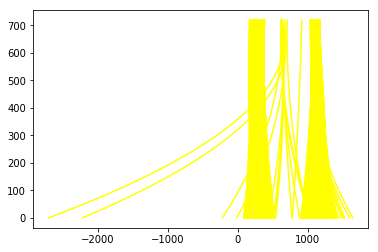

In [65]:
#main_function video process
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML 


white_output = 'output_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("./project_video.mp4").subclip(0,5)
#clip1 = VideoFileClip("./project_video.mp4").subclip(40,43)
#clip1 = VideoFileClip("./project_video.mp4").subclip(23,25)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(image_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [66]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
image = cv2.imread("test_images/" + "straight_lines1.jpg")
image = undistort(image, ret, mtx, dist, rvecs, tvecs)
cv2.imwrite('output_images/'+'Undistorted_straight_line.jpg', image)

transformed = pers_change(image)
cv2.imwrite('output_images/'+'perspective_changed_straight_line.jpg', transformed)
pipe = pipeline(transformed)[0]
binary = binary_warp(pipe)*255
cv2.imwrite('output_images/'+'binary_straight_line.jpg', binary)

fit = fit_polynomial(binary)[0]
cv2.imwrite('output_images/'+'fit_straight_line.jpg', fit)


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML 
white_output = 'output_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("./project_video.mp4").subclip(22,25)
#clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(image_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


width is: 4.19747271871
[MoviePy] >>>> Building video output_challenge_video.mp4
[MoviePy] Writing video output_challenge_video.mp4


  0%|          | 0/76 [00:00<?, ?it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))